**Problem1 Variational Autoencoder**

In [ ]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1
BATCH_SIZE = 128
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

**Load data and necessary libraries**



In [ ]:

i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

conv_shape = K.int_shape(cx)

# Sampling
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

# Reparamertization
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

 **Define Encoder Part: 2 CNN layer with BatchNormalization to extract the feature of images and two dense layer for mu and sigma. The first CNN use 8 filters with 3*3 kernel size, so this layer makes 8 feature maps.
The second CNN use 16 filter with 3*3 kernels. At the end we use two dense layer for mu and sigma respectively.** 

In [ ]:
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)
decoder = Model(d_i, o, name='decoder')
decoder.summary()

**Define Decoder Part: In an opsite manner to Encoder**

In [ ]:
vae_outputs = decoder(encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

**Concatenate Decoder and Encoder part**

In [ ]:
def kl_reconstruction_loss(true, pred):
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  return K.mean(reconstruction_loss + kl_loss)

**Define Loss Function: We use KL-Divergance and Binary-Crossentropy for latent space and reconsuction part respectively**

In [ ]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)




Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 14, 14, 8)    80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_37 (BatchNo (None, 14, 14, 8)    32          conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 7, 7, 16)     1168        batch_normalization_37[0][0]     
____________________________________________________________________________________________

In [ ]:
 def plot_diagram(vae_loss, epoch):

    plt.figure(figsize=(15, 6))
    plt.plot(list(range(1, epoch + 2)),vae_loss, linewidth=3)
    plt.legend(['VAE'])

    plt.title("Loss Values")
    plt.ylabel("Loss")
    plt.xticks(list(range(1, epoch + 1)))
    plt.xlabel('epoch')
    plt.grid(which='both', axis='both')
    plt.show()
 def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    #plt.show()
    plt.savefig('/content/drive/My Drive/NeuralNet/Q1/Latent_Epoch_%d.png' % epoch, bbox_inches='tight')
    plt.close()

 def viz_decoded(encoder, decoder, data, epoch):
    num_samples = 15
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
                    j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(10, 10))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
      figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.savefig('/content/drive/My Drive/NeuralNet/Q1/Epoch_%d.png' % epoch, bbox_inches='tight')
    plt.close()

**Define Visulaize and Loss-Function diagram**

**************************** Epoch:  0


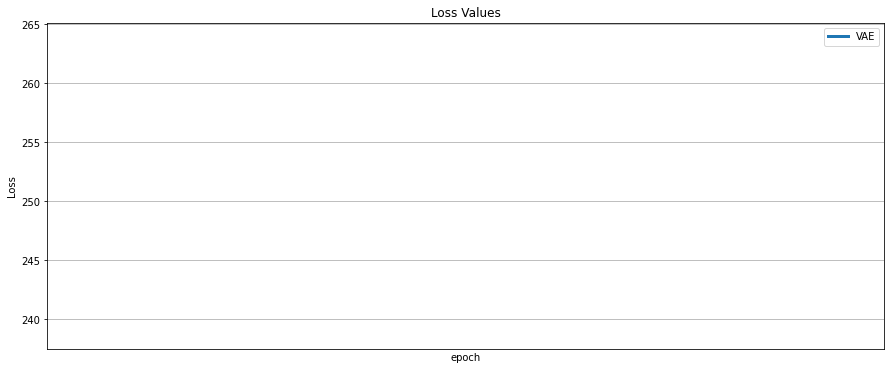

**************************** Epoch:  1


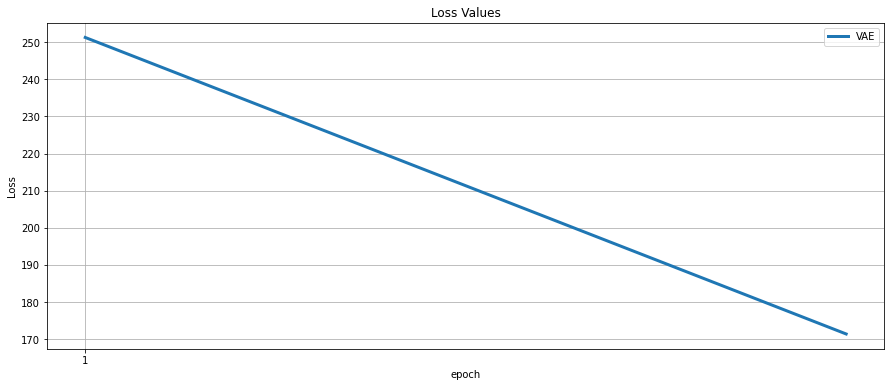

**************************** Epoch:  2


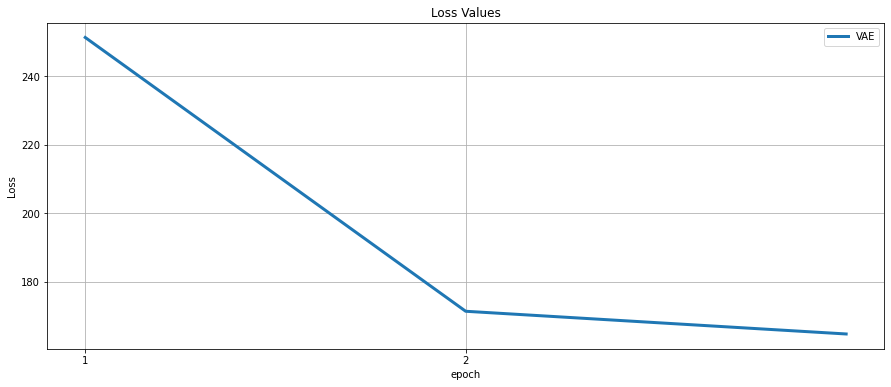

**************************** Epoch:  3


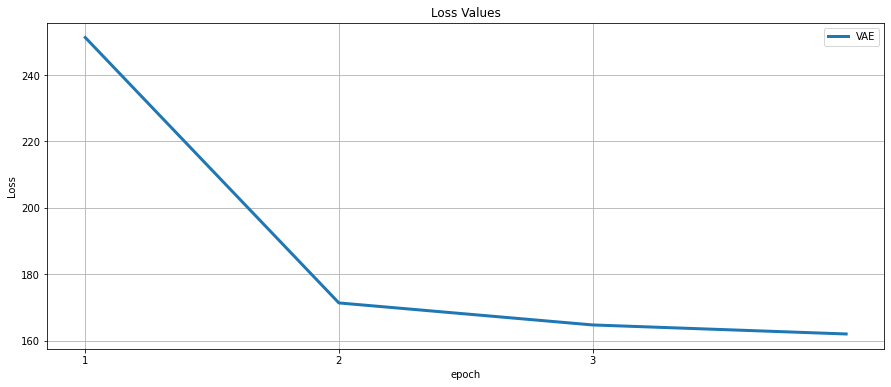

**************************** Epoch:  4


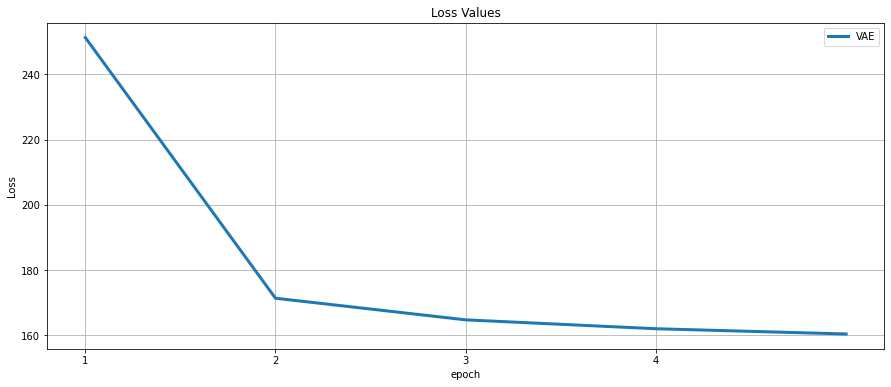

**************************** Epoch:  5


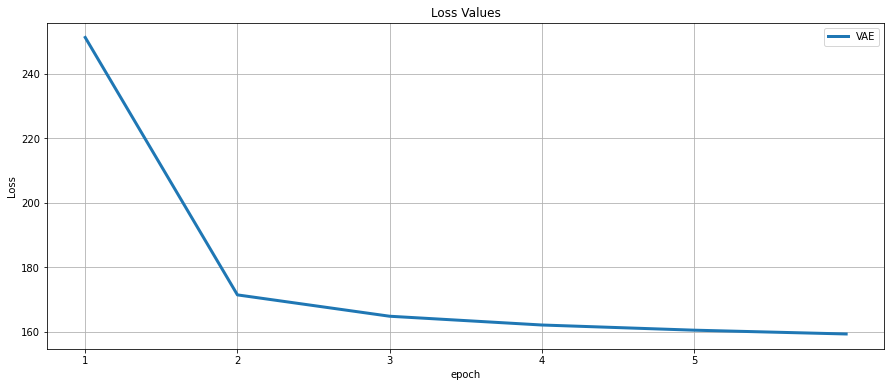

**************************** Epoch:  6


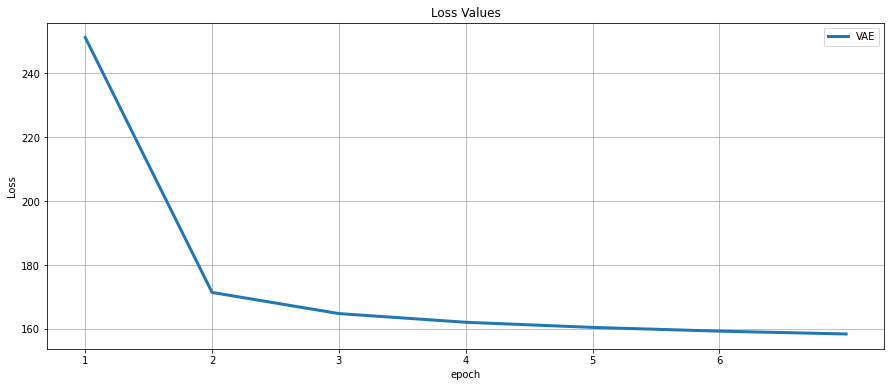

**************************** Epoch:  7


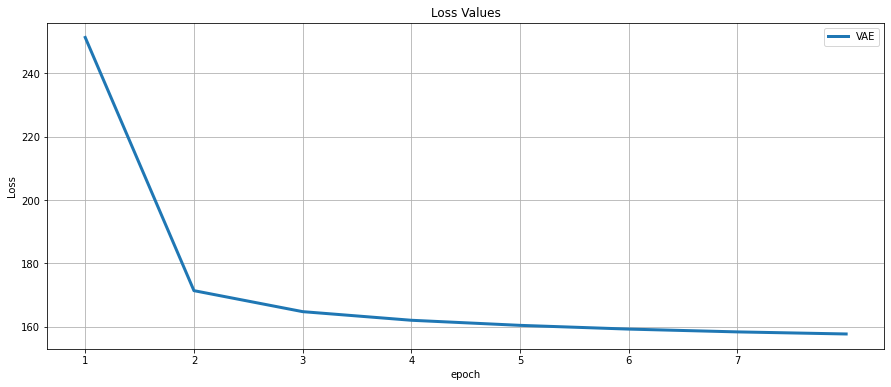

**************************** Epoch:  8


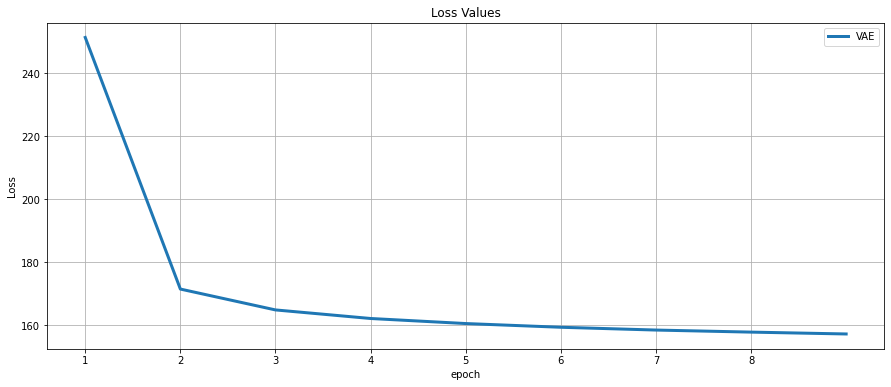

**************************** Epoch:  9


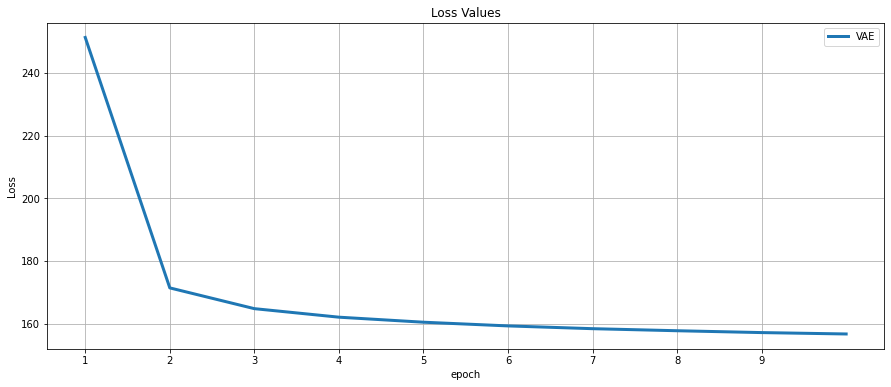

**************************** Epoch:  10


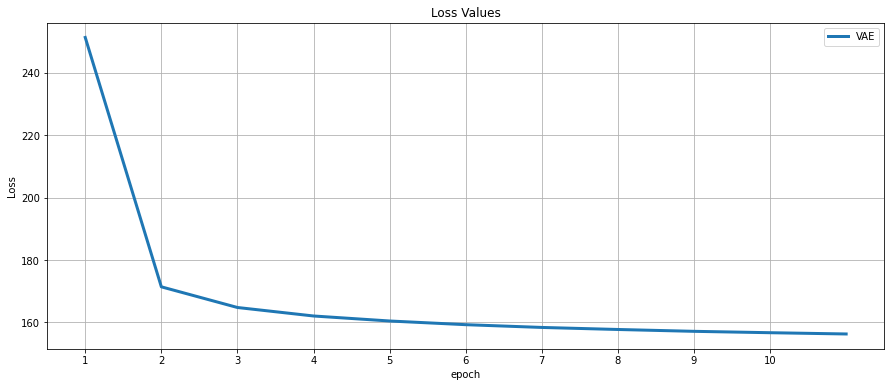

**************************** Epoch:  11


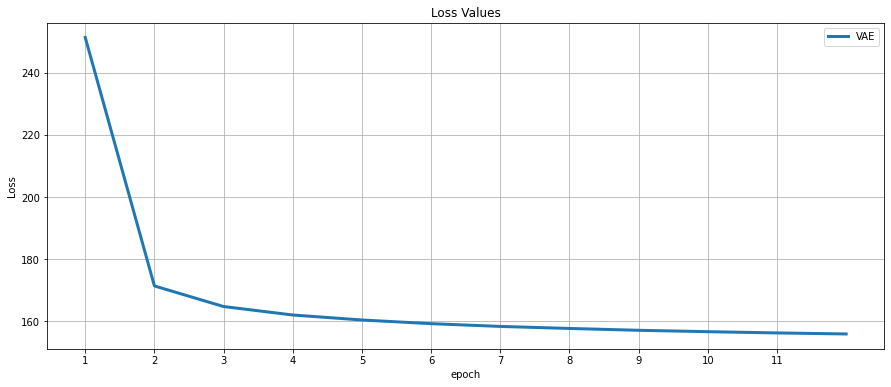

**************************** Epoch:  12


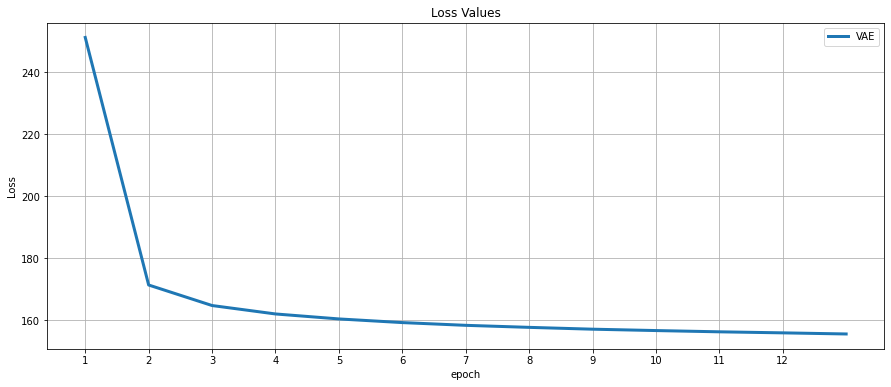

**************************** Epoch:  13


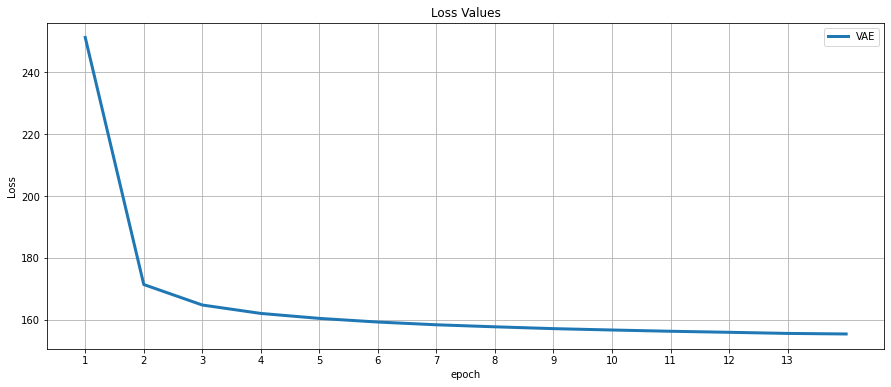

**************************** Epoch:  14


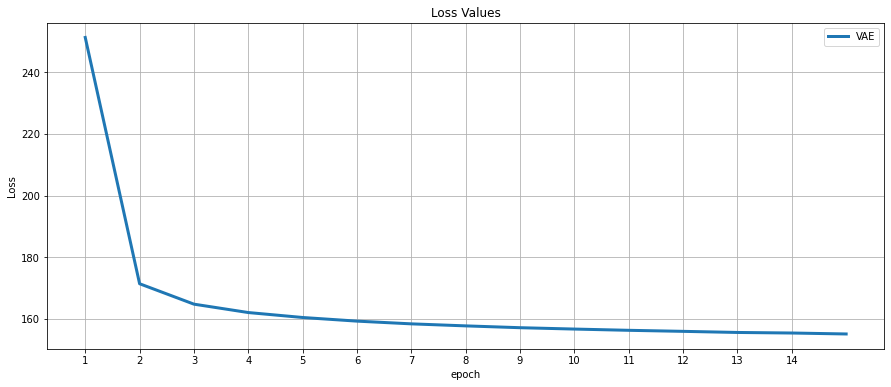

**************************** Epoch:  15


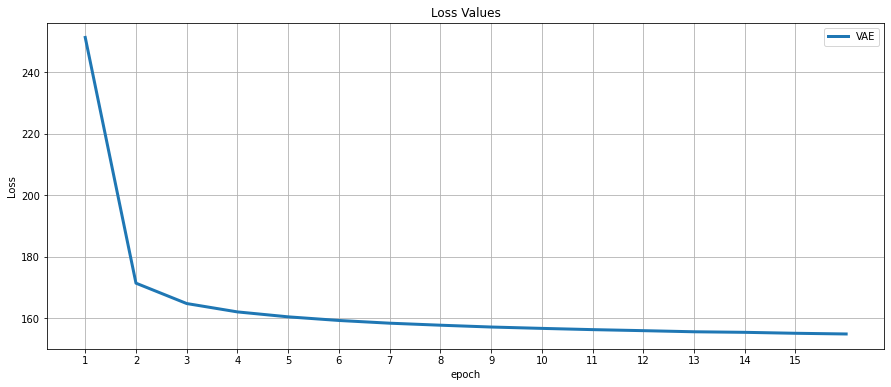

**************************** Epoch:  16


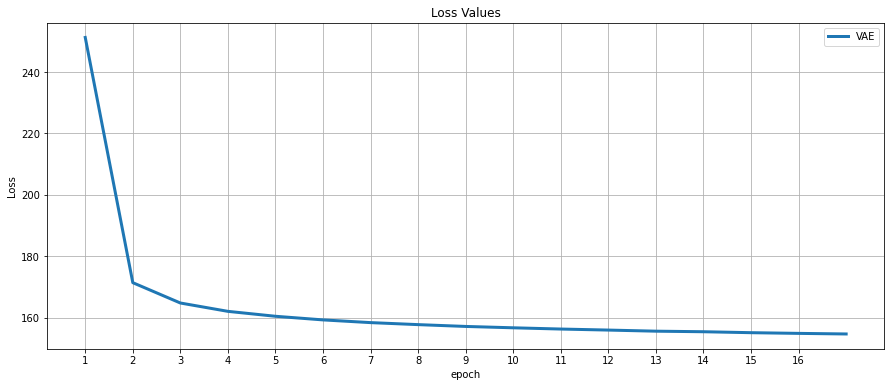

**************************** Epoch:  17


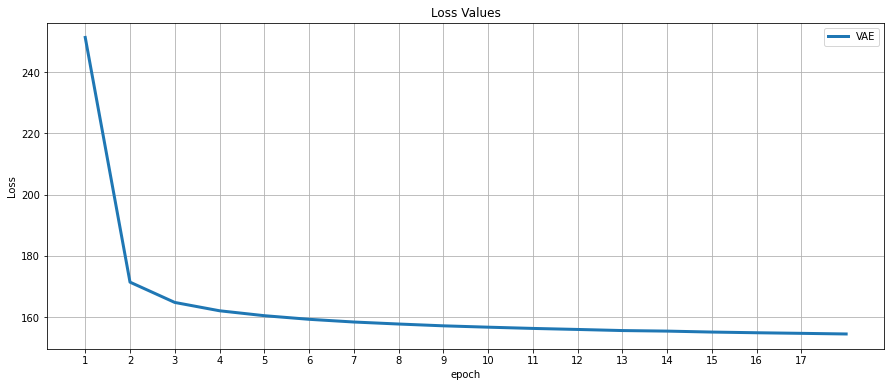

**************************** Epoch:  18


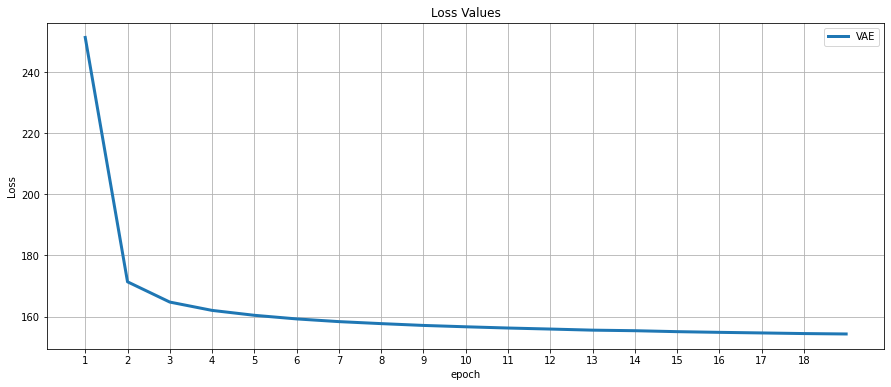

**************************** Epoch:  19


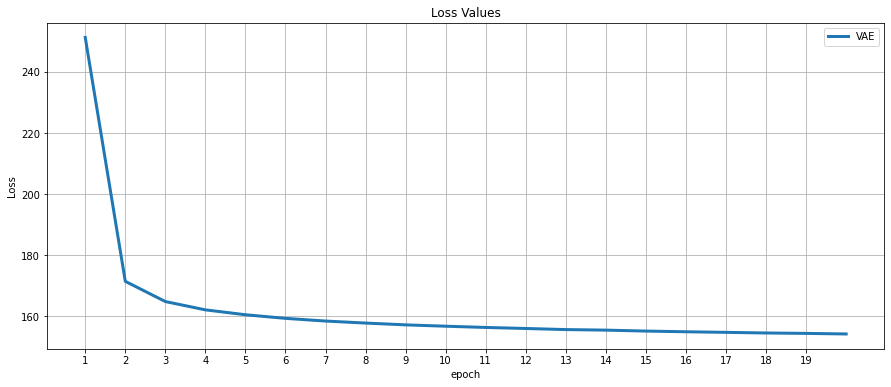

**************************** Epoch:  20


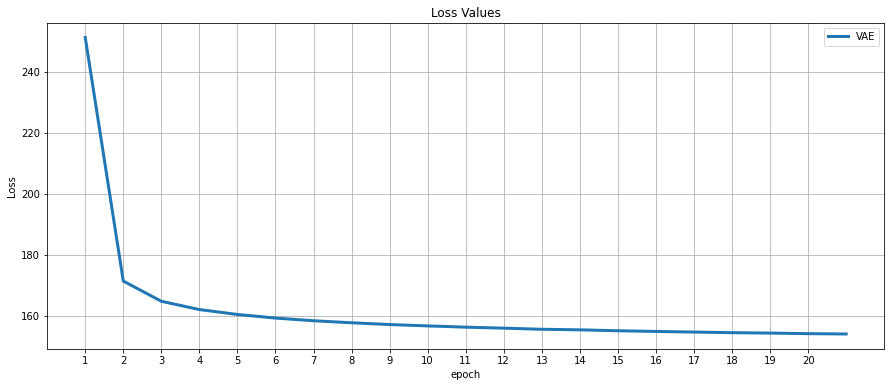

**************************** Epoch:  21


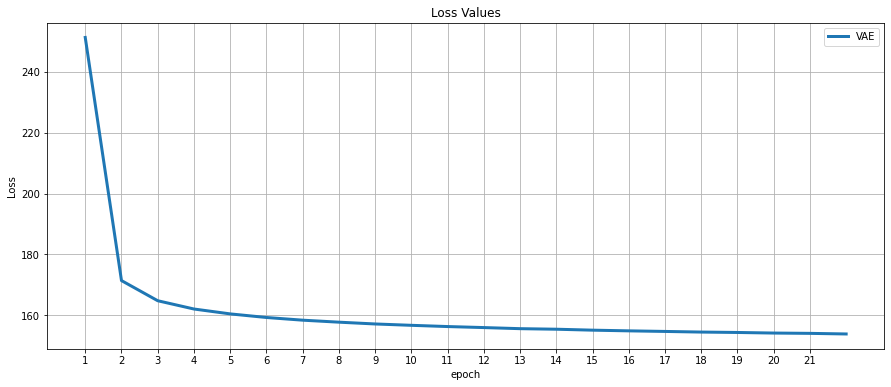

**************************** Epoch:  22


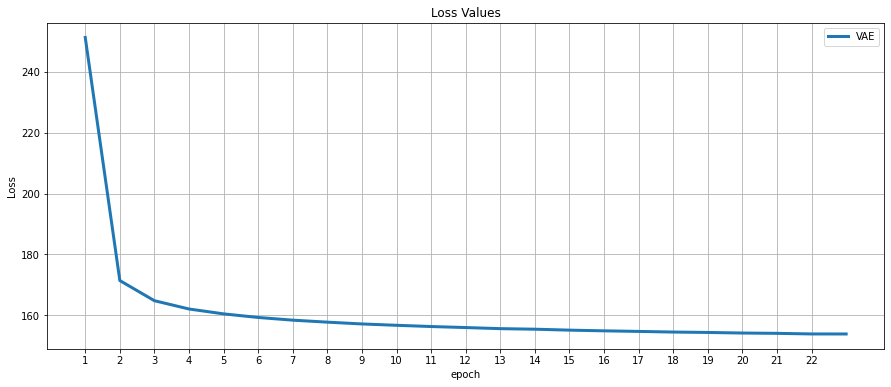

**************************** Epoch:  23


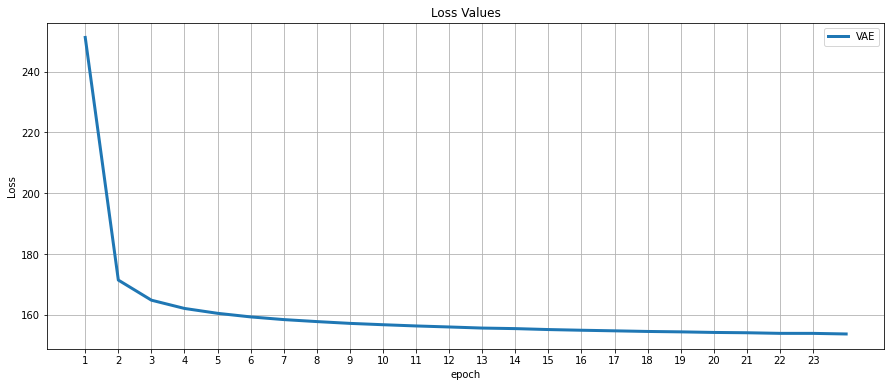

**************************** Epoch:  24


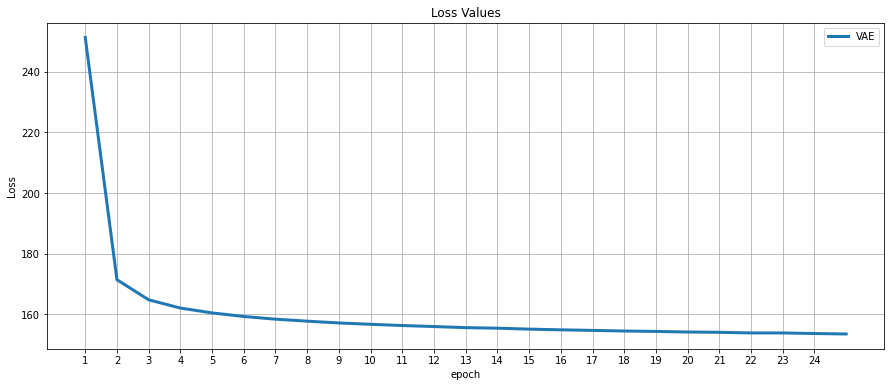

**************************** Epoch:  25


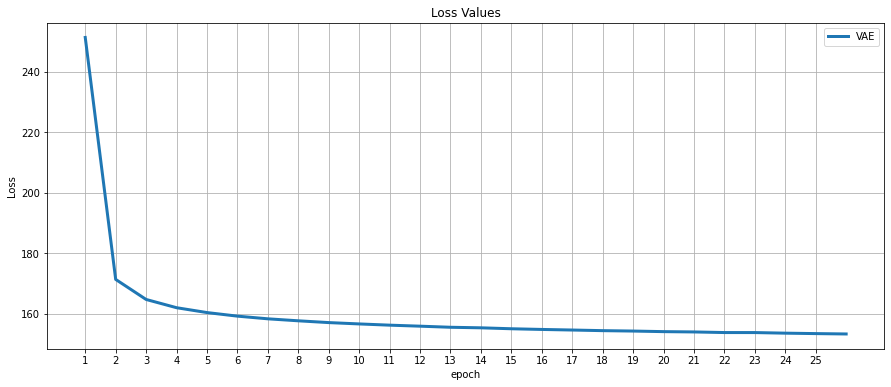

**************************** Epoch:  26


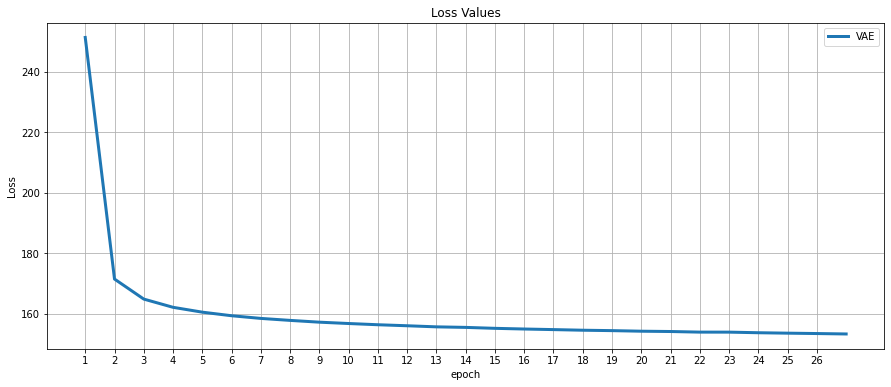

**************************** Epoch:  27


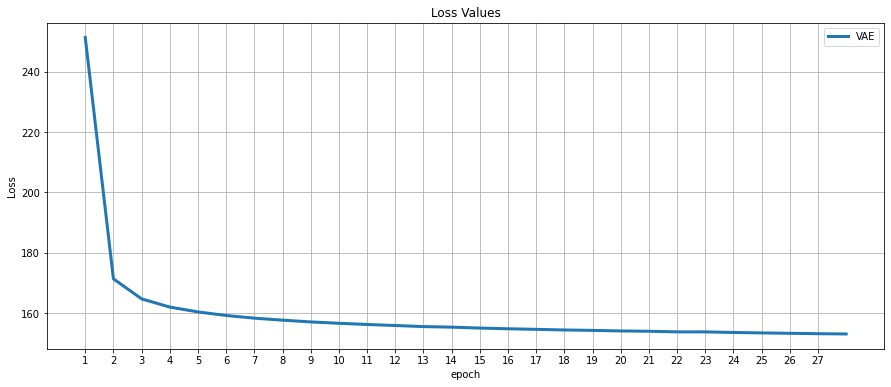

**************************** Epoch:  28


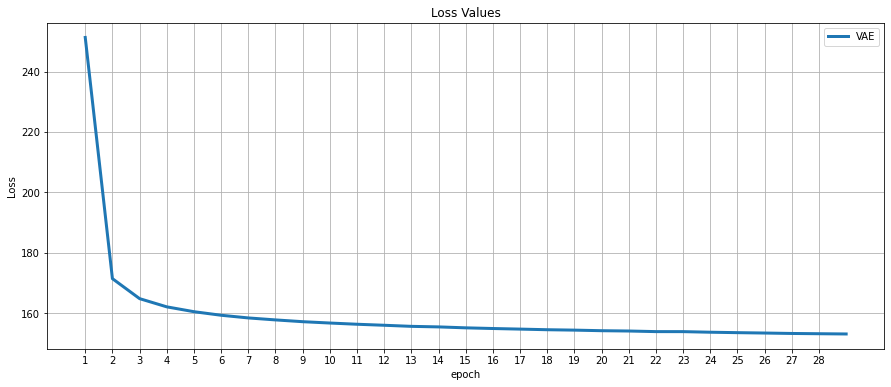

**************************** Epoch:  29


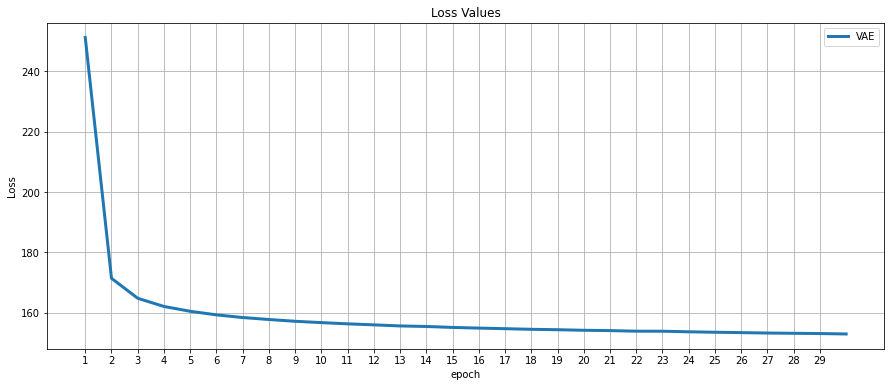

**************************** Epoch:  30


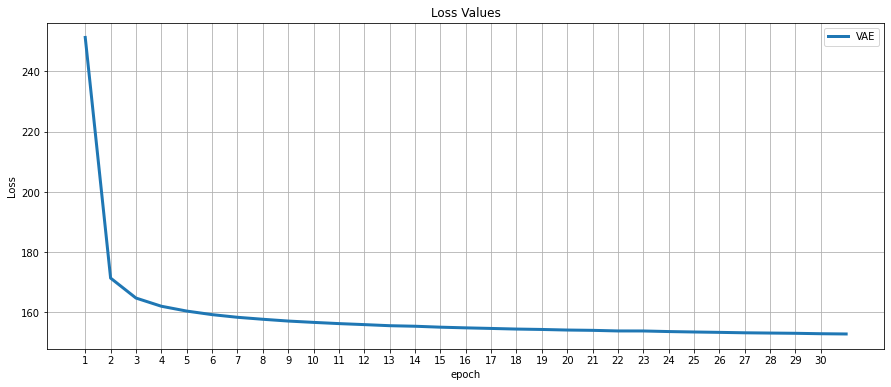

**************************** Epoch:  31


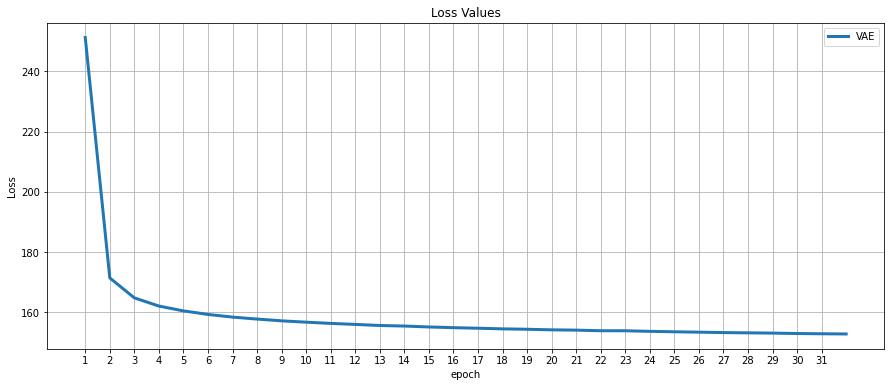

**************************** Epoch:  32


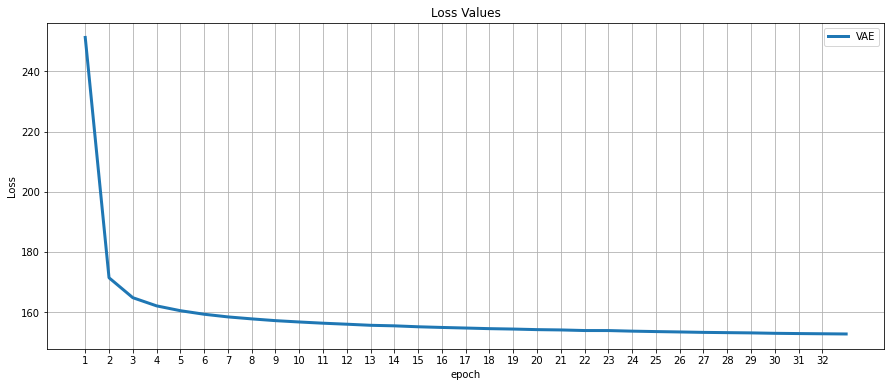

**************************** Epoch:  33


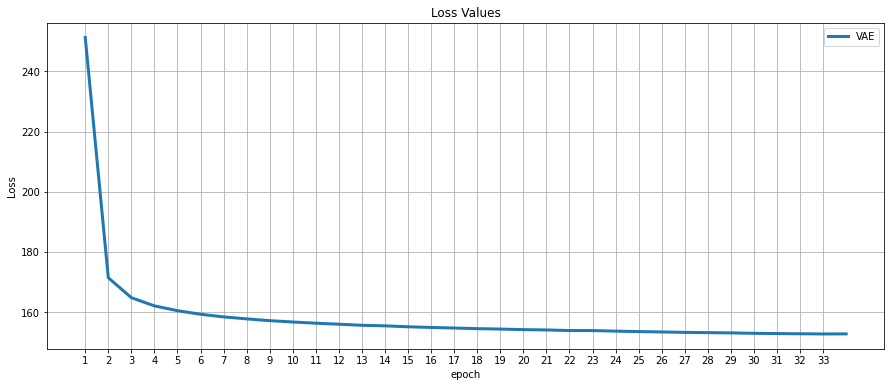

**************************** Epoch:  34


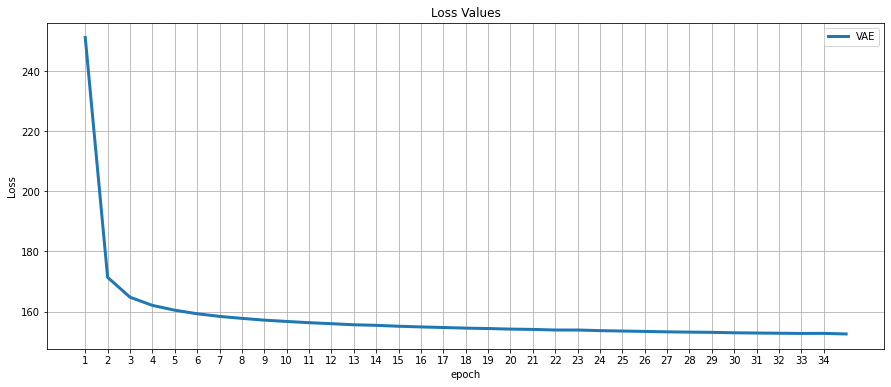

**************************** Epoch:  35


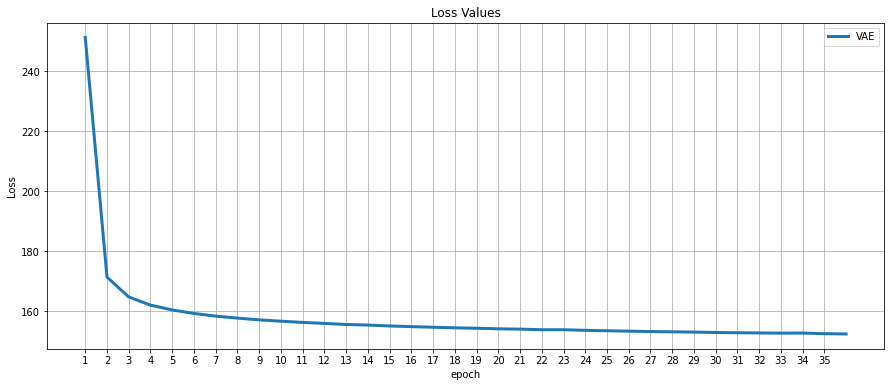

**************************** Epoch:  36


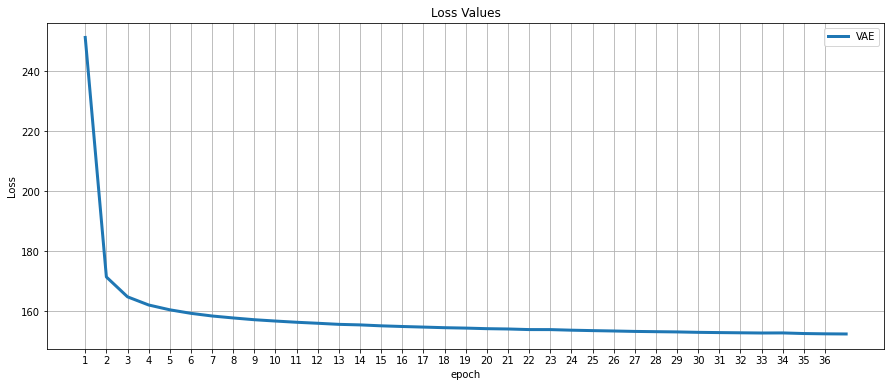

**************************** Epoch:  37


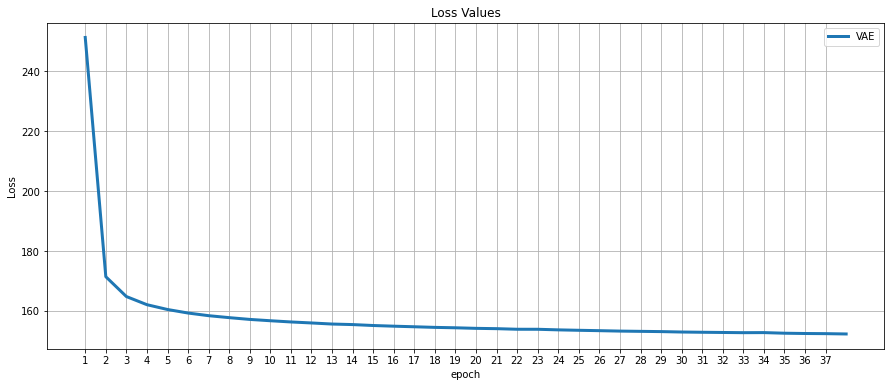

**************************** Epoch:  38


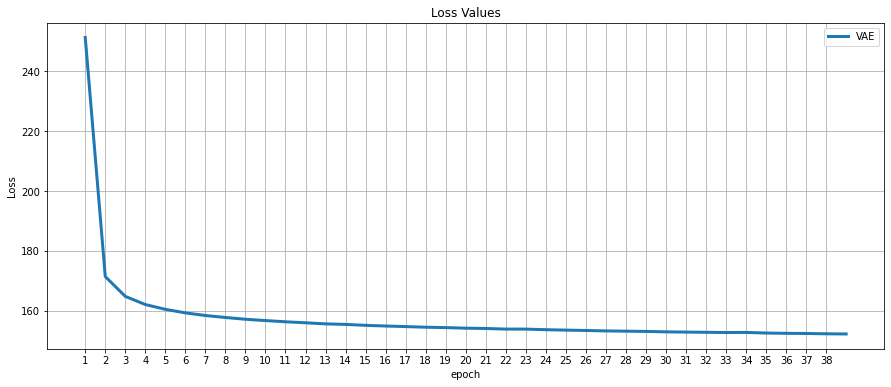

**************************** Epoch:  39


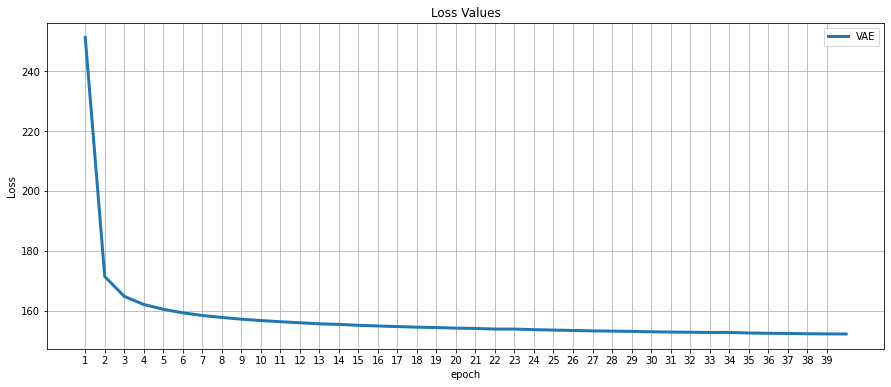

**************************** Epoch:  40


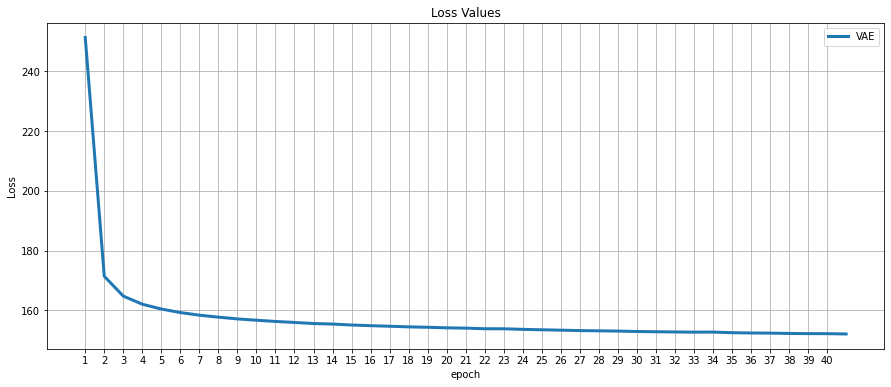

**************************** Epoch:  41


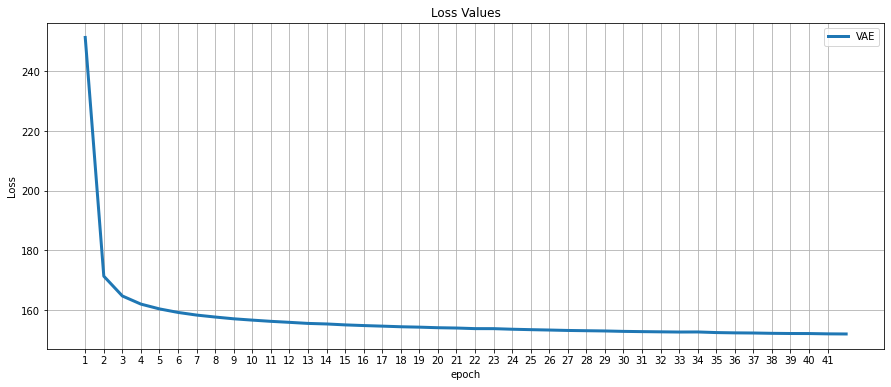

**************************** Epoch:  42


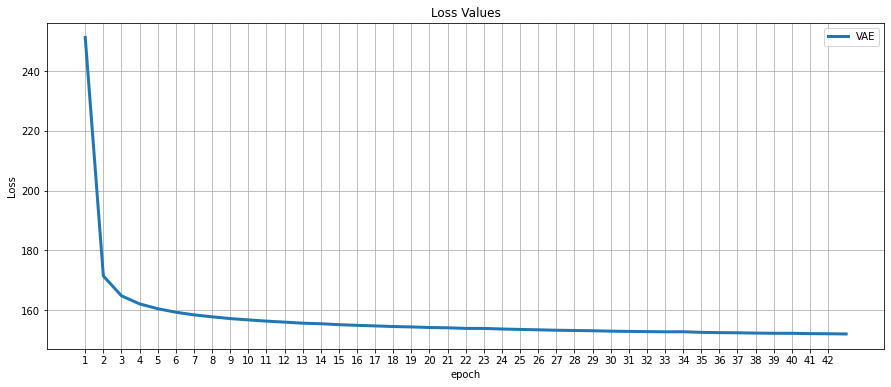

**************************** Epoch:  43


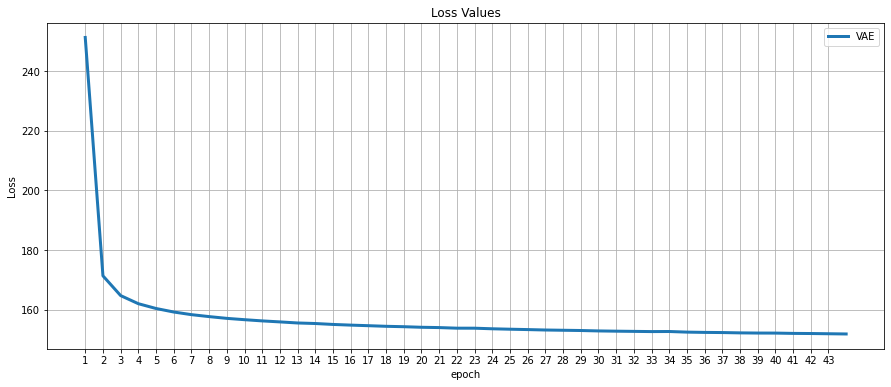

**************************** Epoch:  44


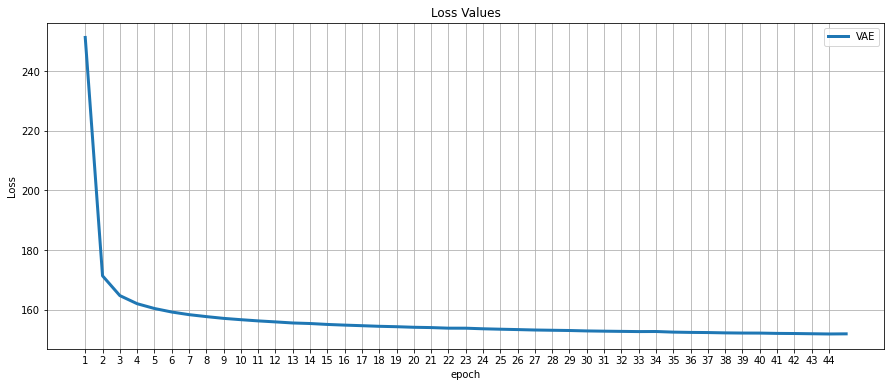

**************************** Epoch:  45


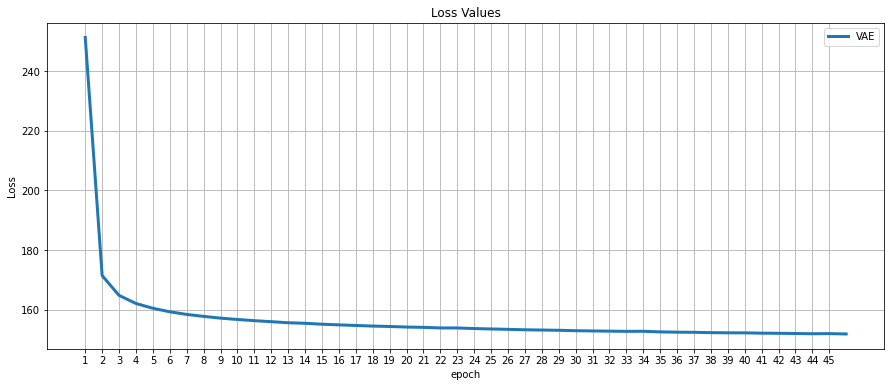

**************************** Epoch:  46


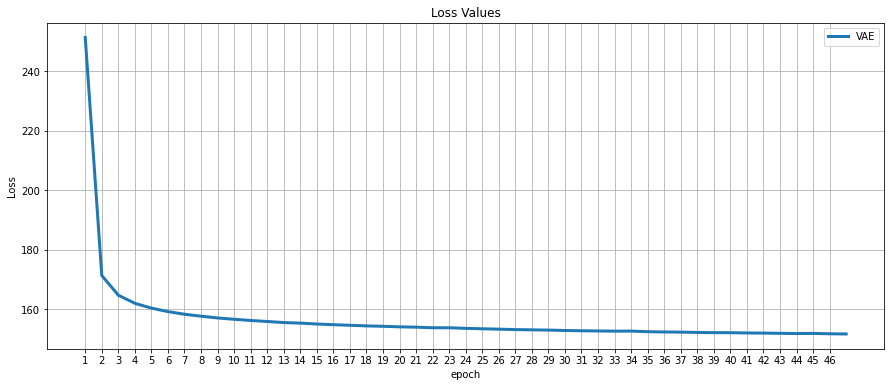

**************************** Epoch:  47


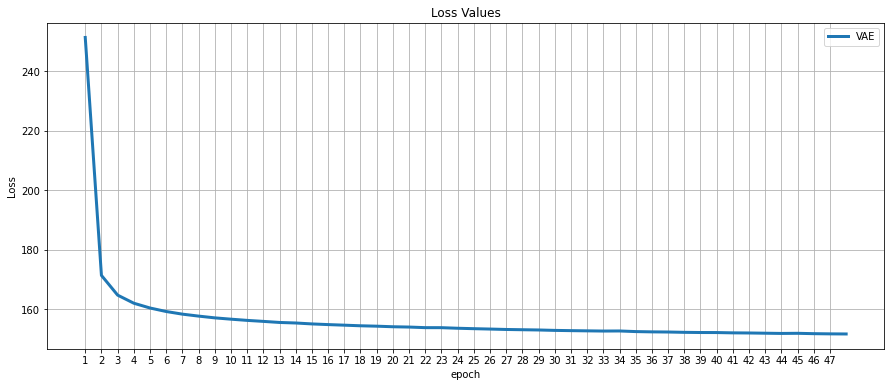

**************************** Epoch:  48


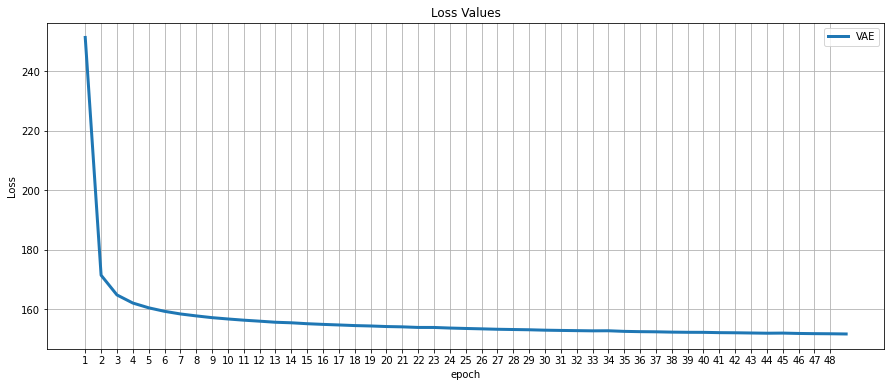

**************************** Epoch:  49


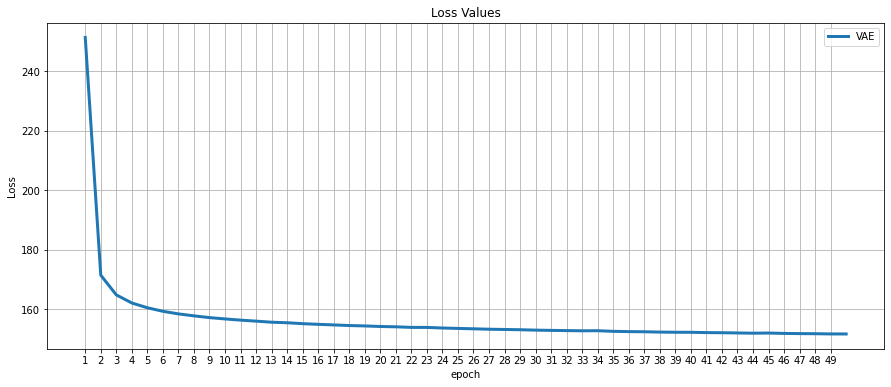

**************************** Epoch:  50


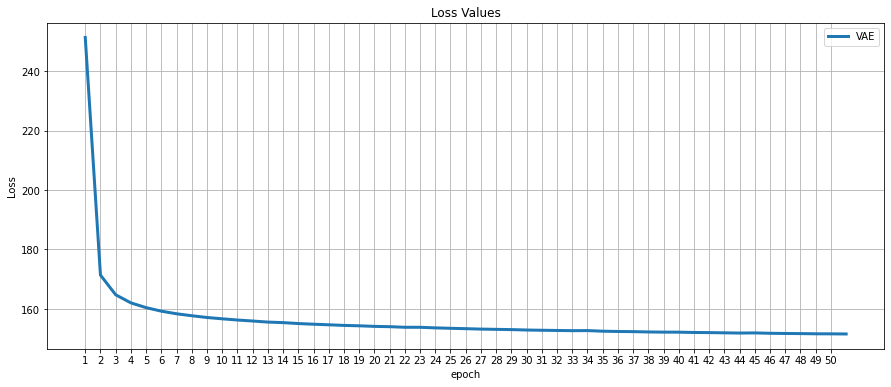

**************************** Epoch:  51


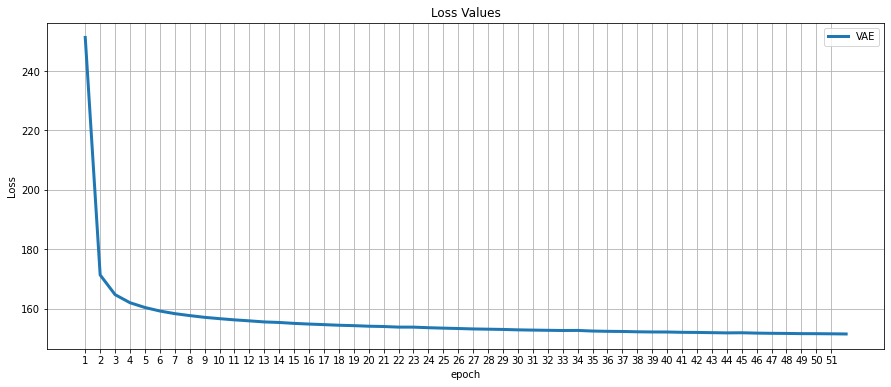

**************************** Epoch:  52


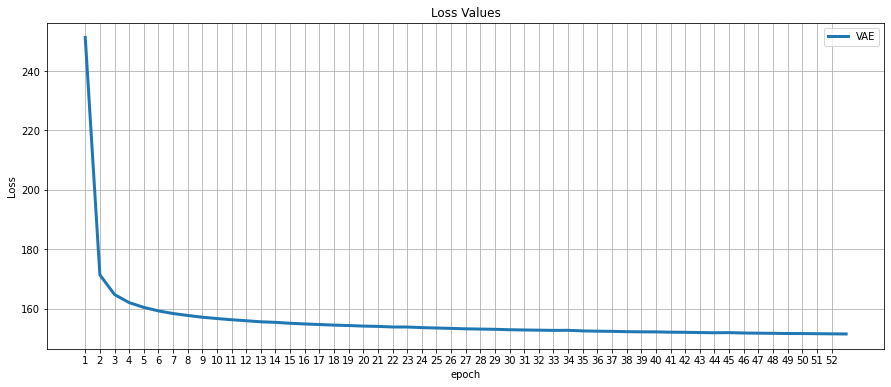

**************************** Epoch:  53


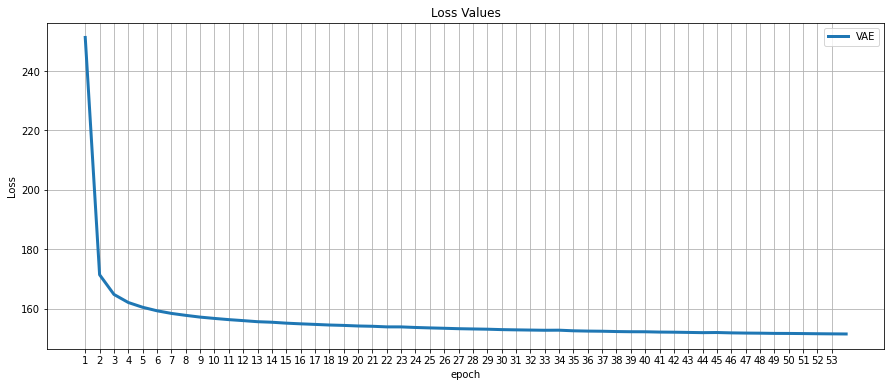

**************************** Epoch:  54


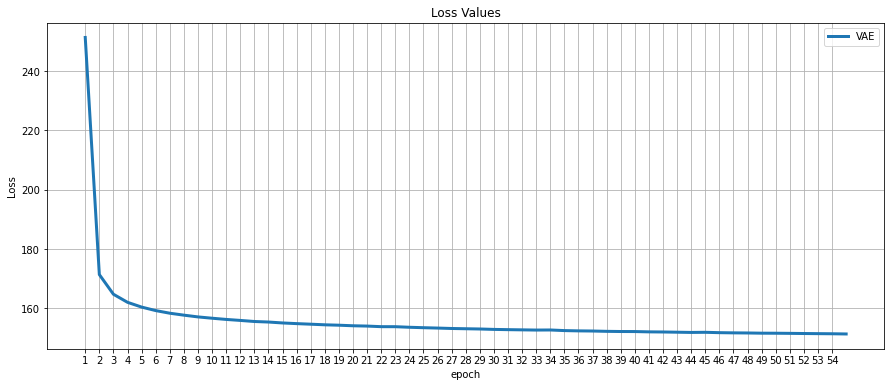

**************************** Epoch:  55


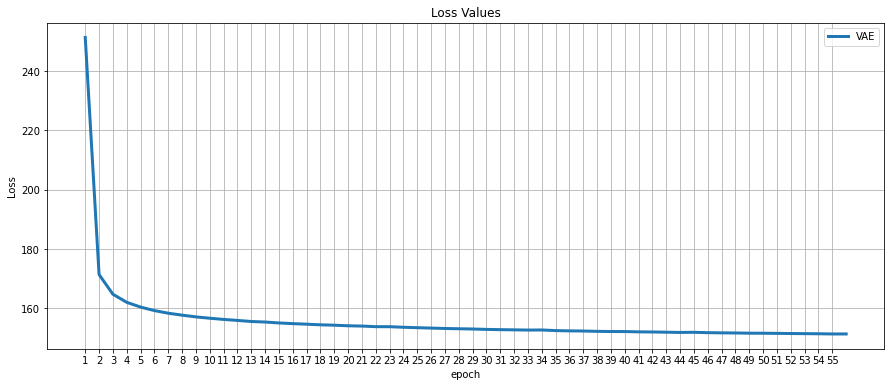

**************************** Epoch:  56


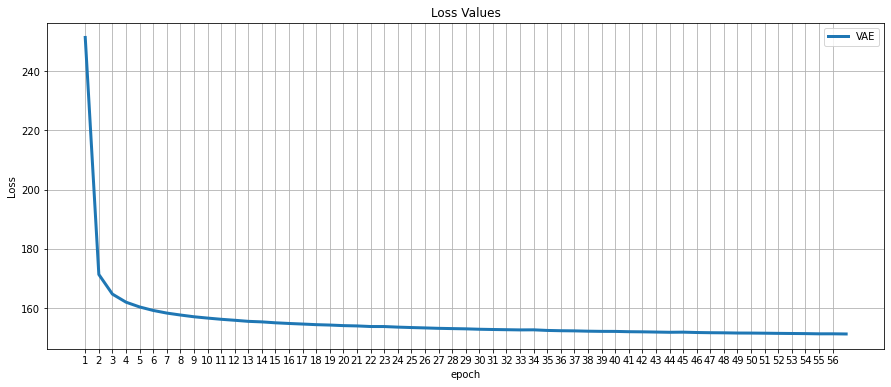

**************************** Epoch:  57


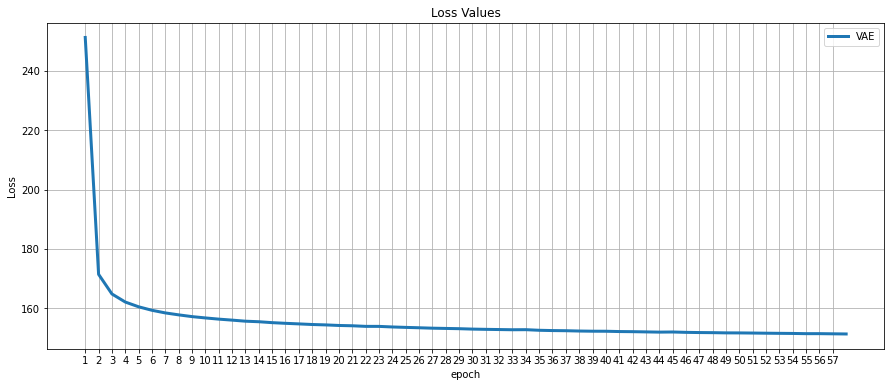

**************************** Epoch:  58


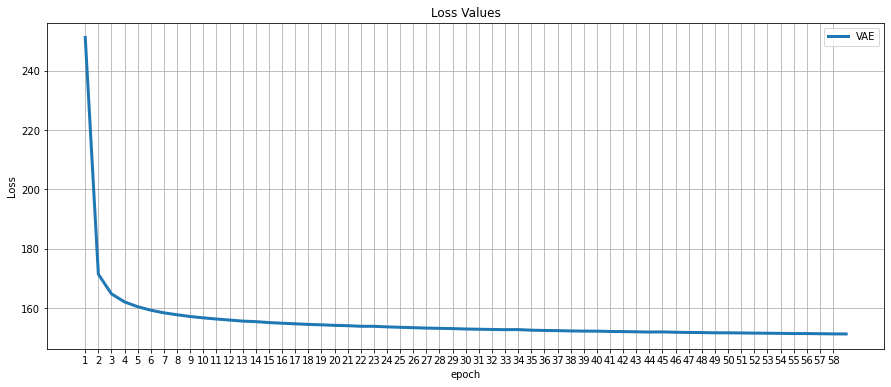

**************************** Epoch:  59


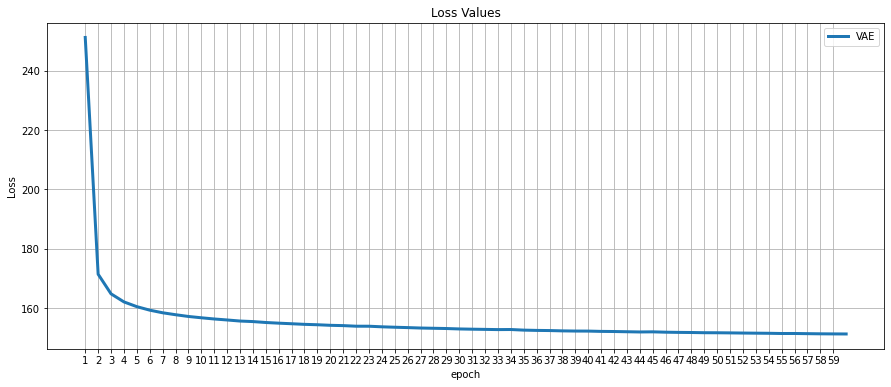

**************************** Epoch:  60


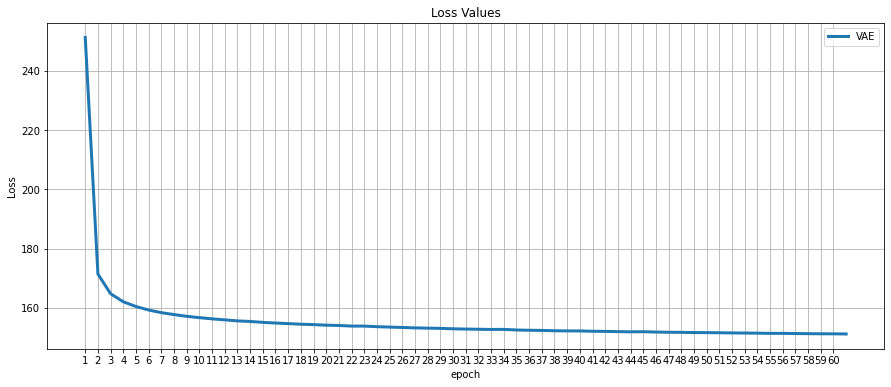

**************************** Epoch:  61


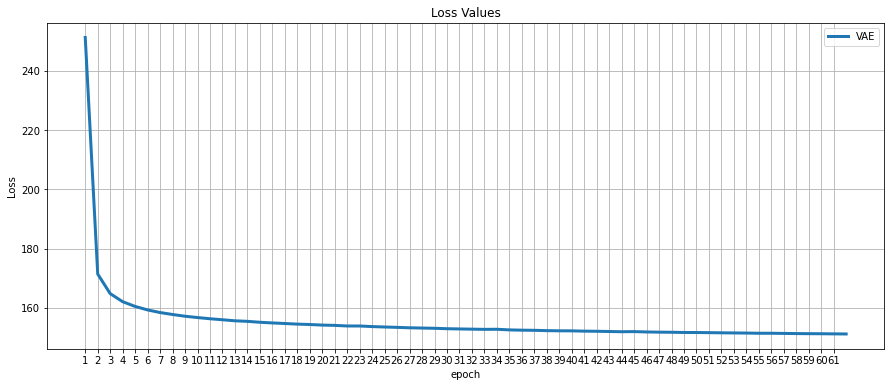

**************************** Epoch:  62


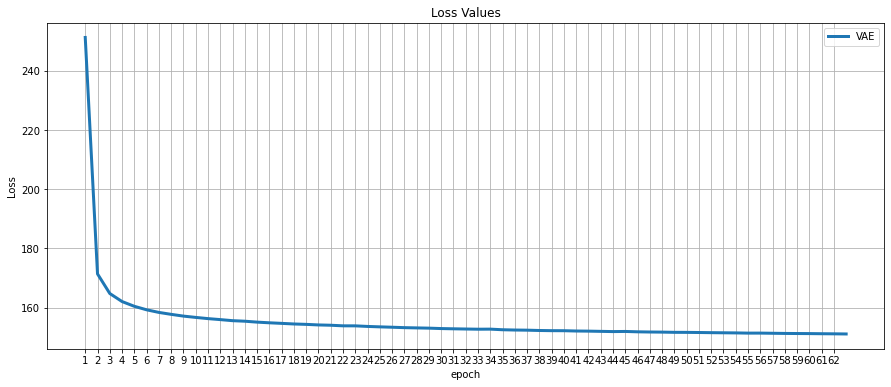

**************************** Epoch:  63


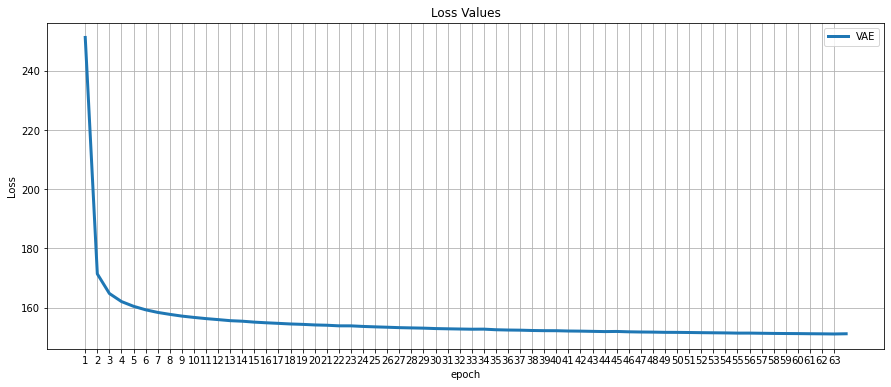

**************************** Epoch:  64


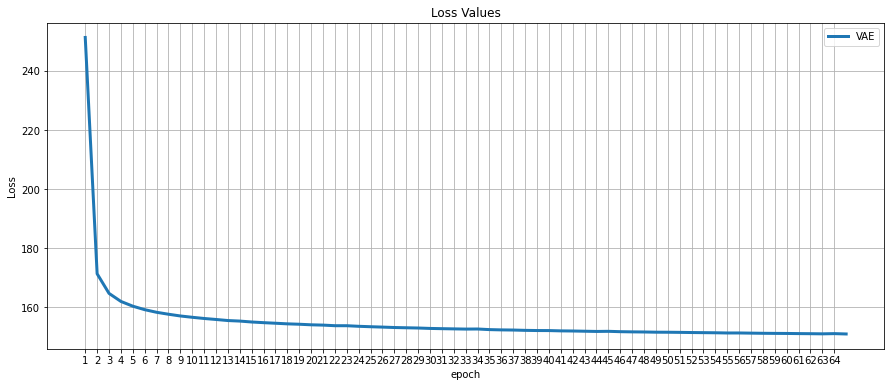

**************************** Epoch:  65


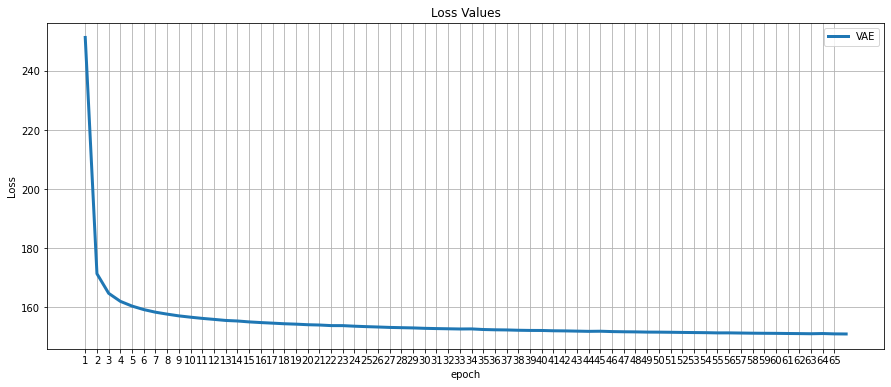

**************************** Epoch:  66


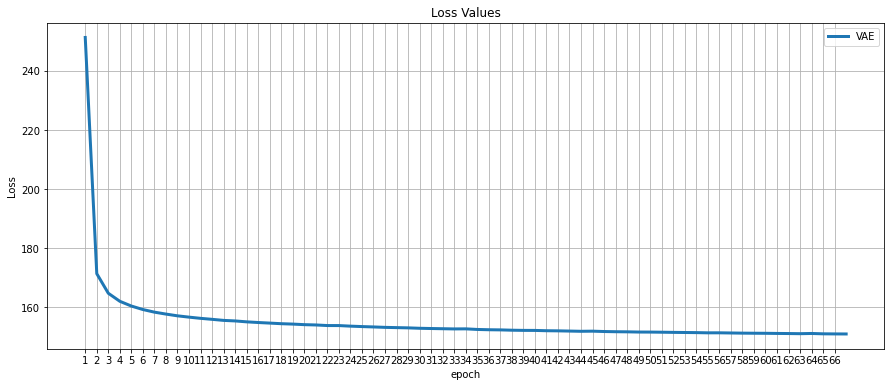

**************************** Epoch:  67


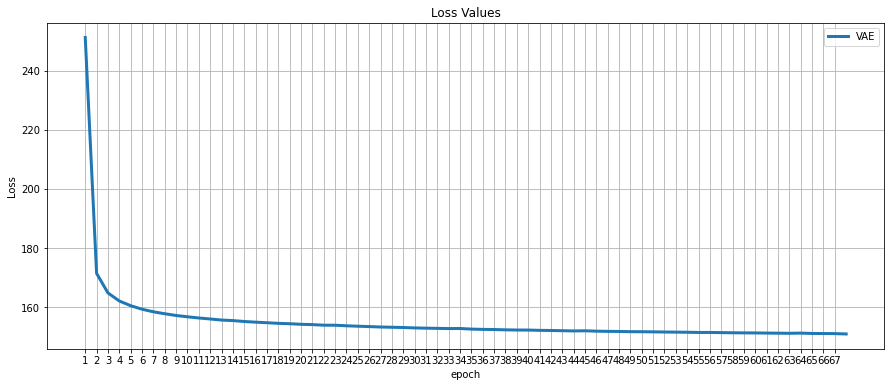

**************************** Epoch:  68


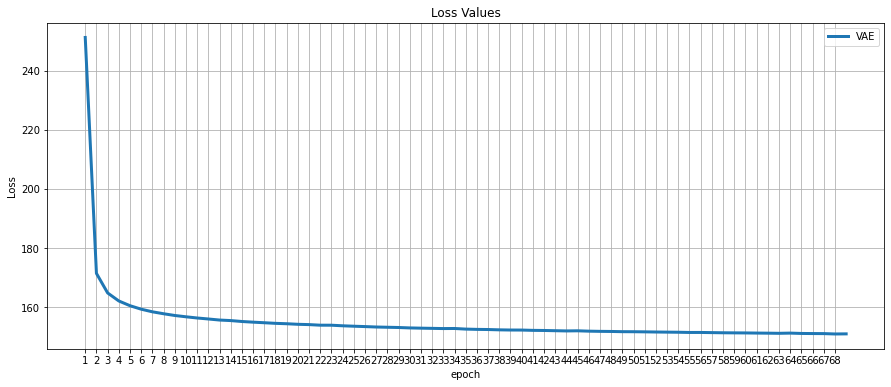

**************************** Epoch:  69


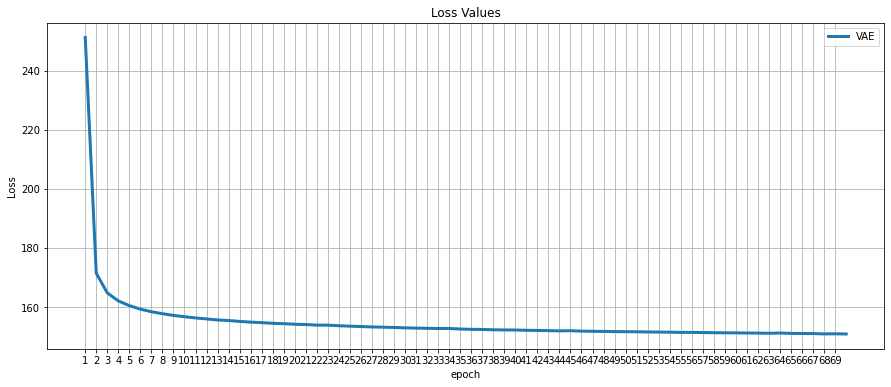

**************************** Epoch:  70


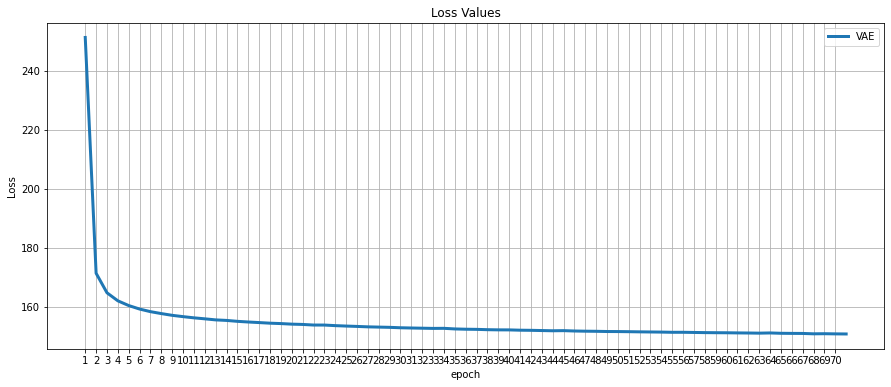

**************************** Epoch:  71


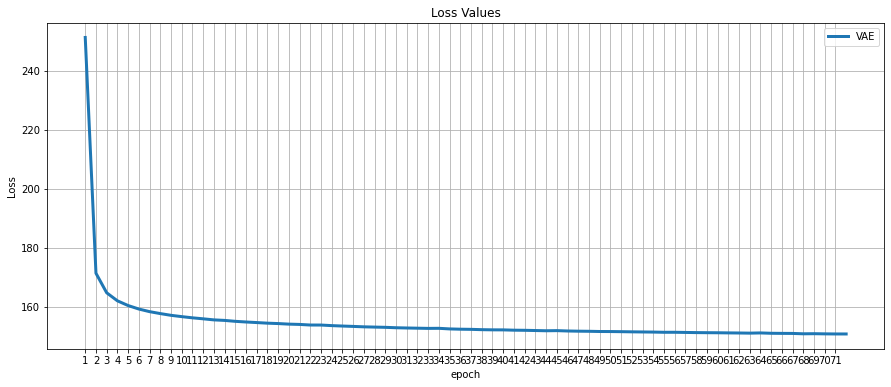

**************************** Epoch:  72


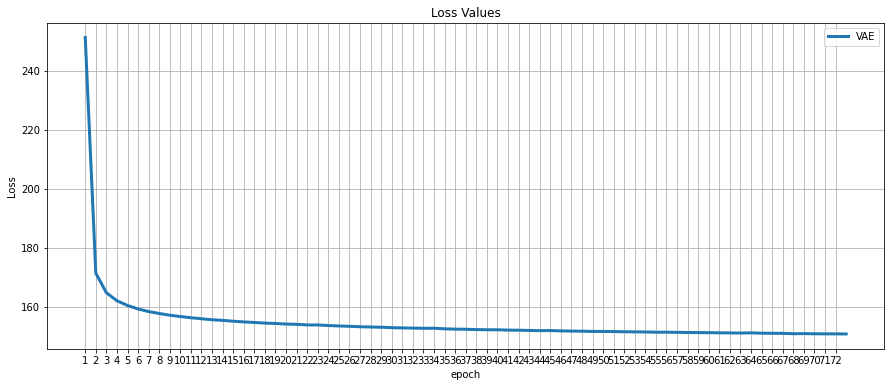

**************************** Epoch:  73


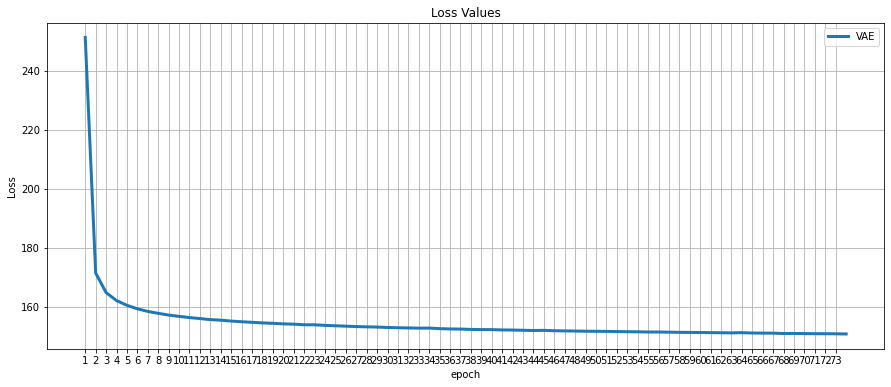

**************************** Epoch:  74


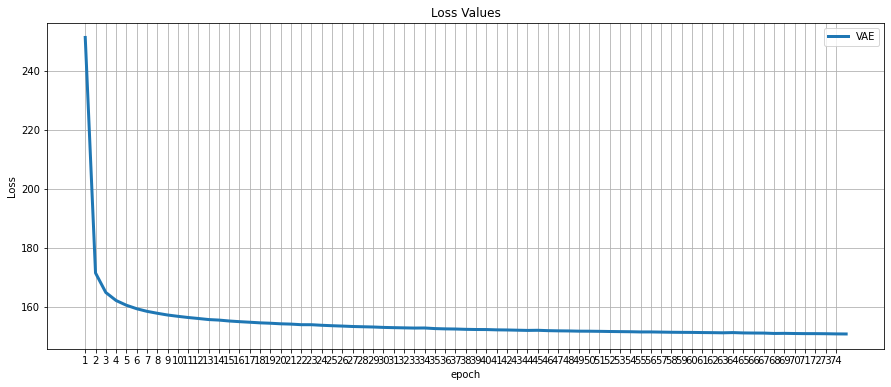

**************************** Epoch:  75


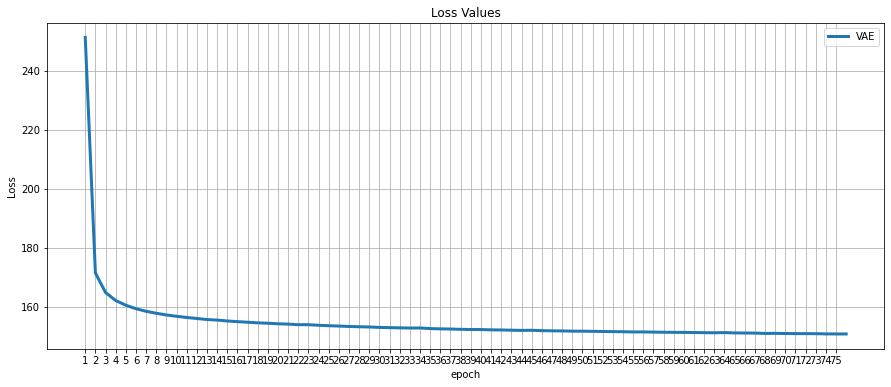

**************************** Epoch:  76


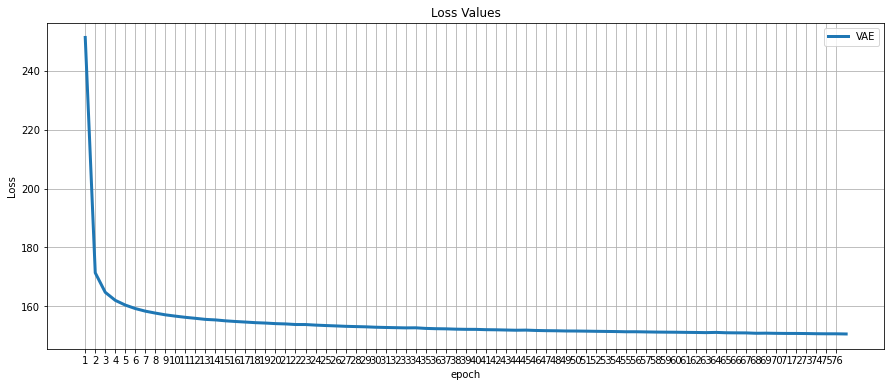

**************************** Epoch:  77


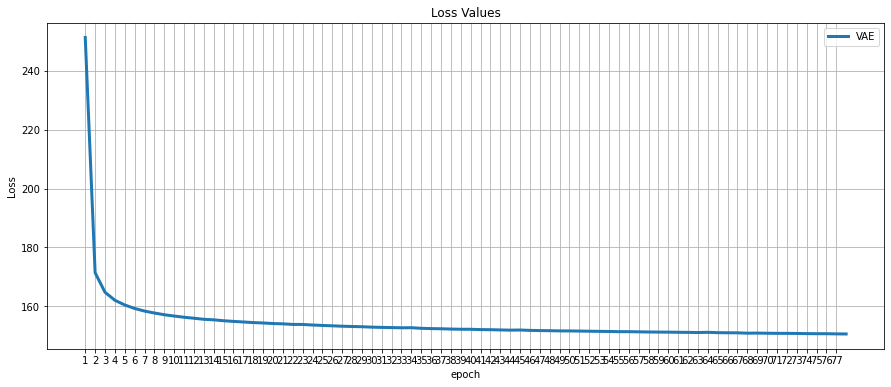

**************************** Epoch:  78


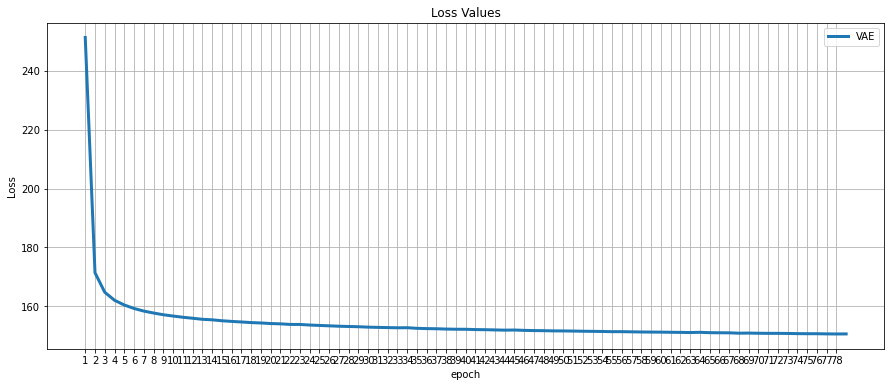

**************************** Epoch:  79


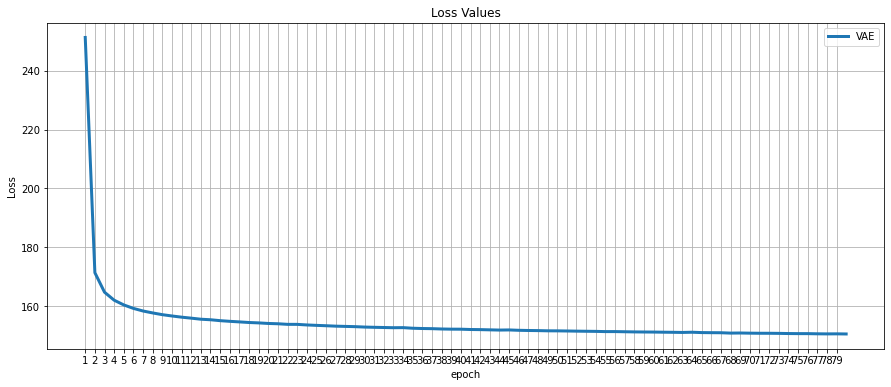

**************************** Epoch:  80


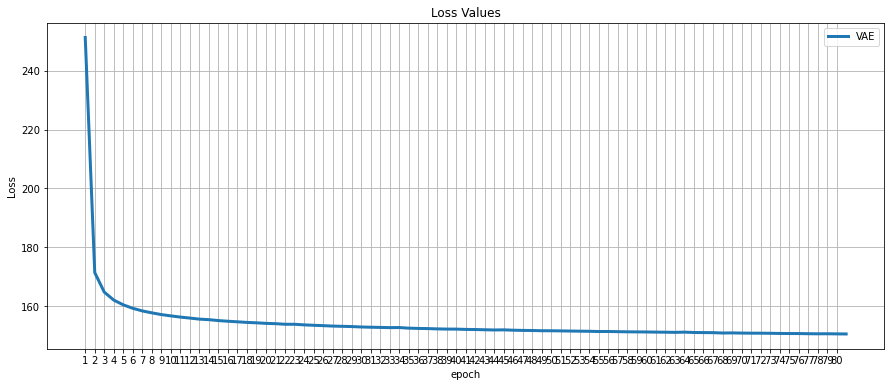

**************************** Epoch:  81


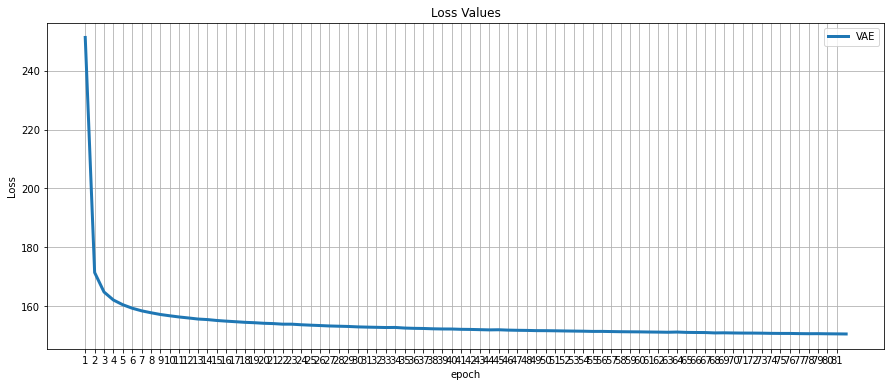

**************************** Epoch:  82


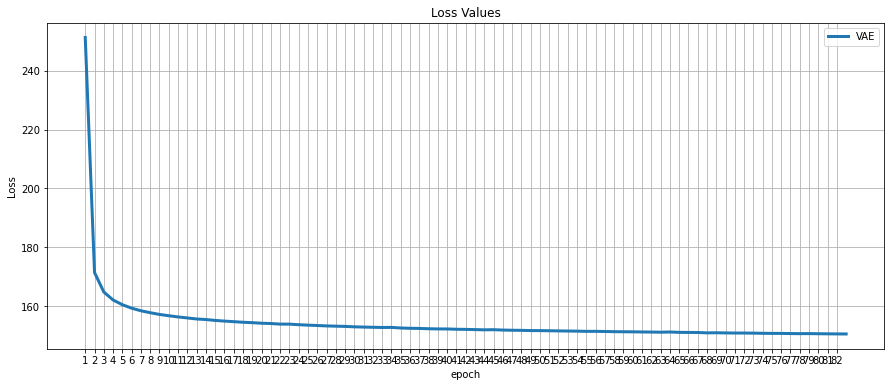

**************************** Epoch:  83


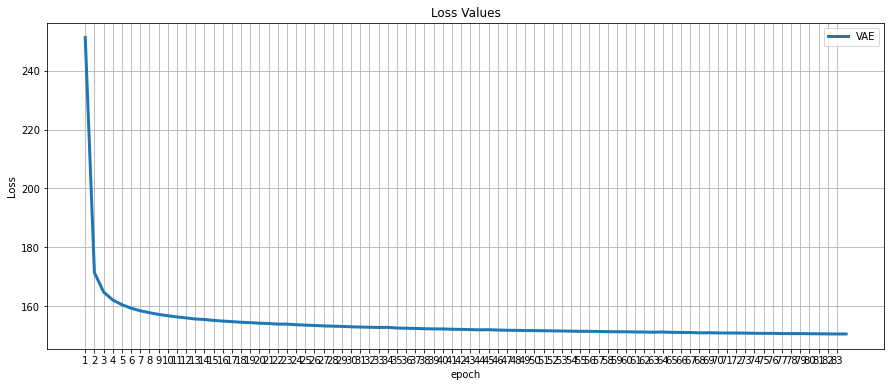

**************************** Epoch:  84


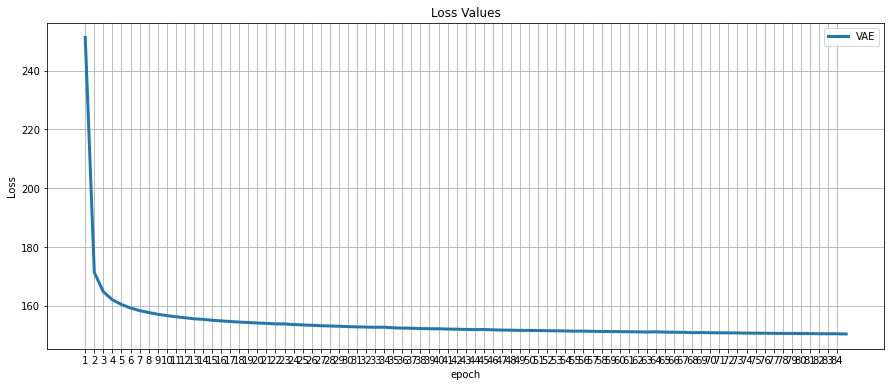

**************************** Epoch:  85


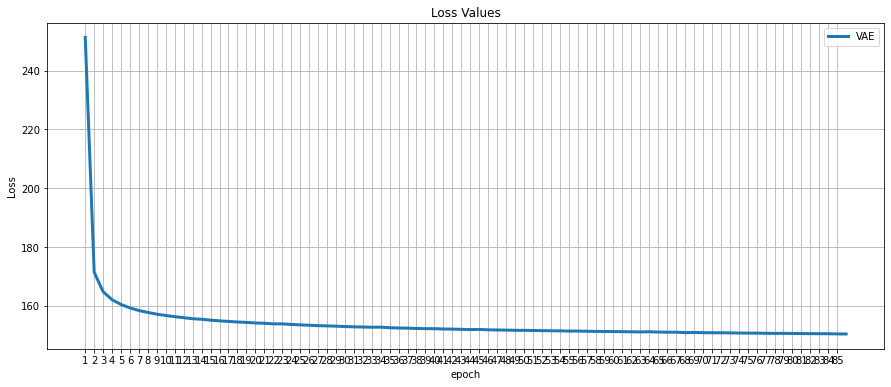

**************************** Epoch:  86


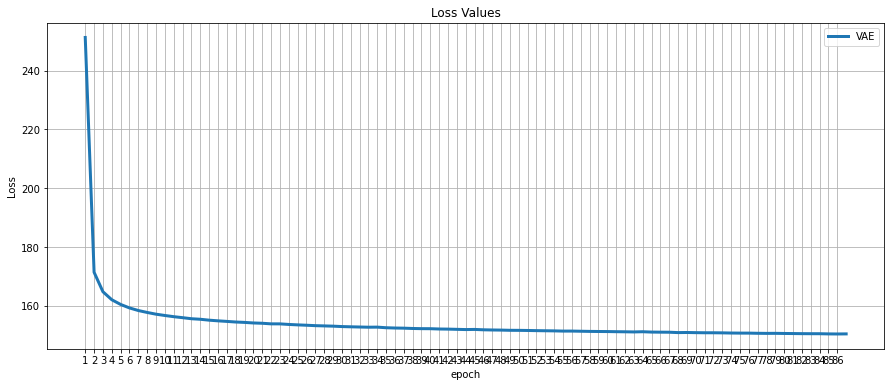

**************************** Epoch:  87


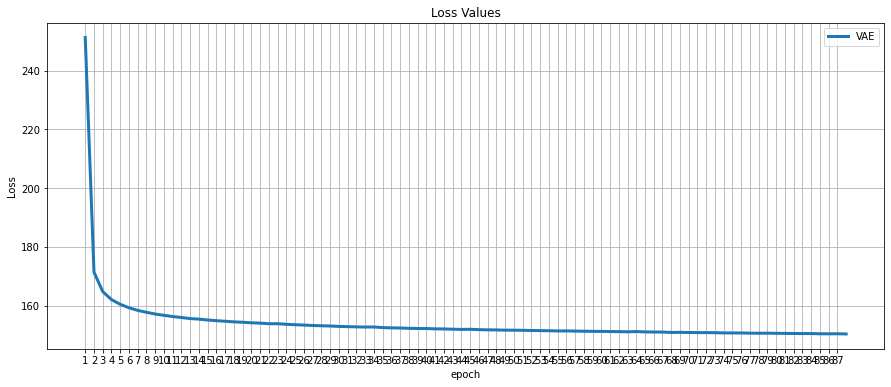

**************************** Epoch:  88


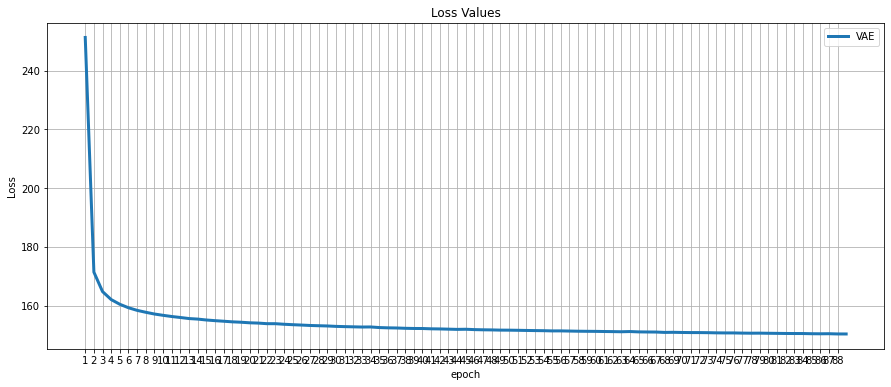

**************************** Epoch:  89


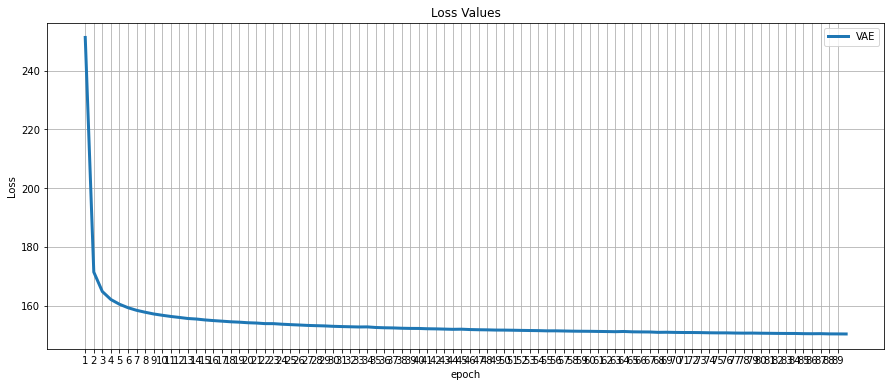

**************************** Epoch:  90


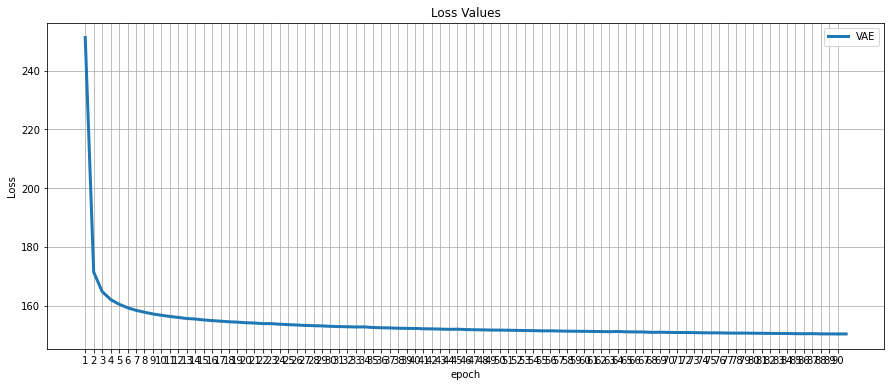

**************************** Epoch:  91


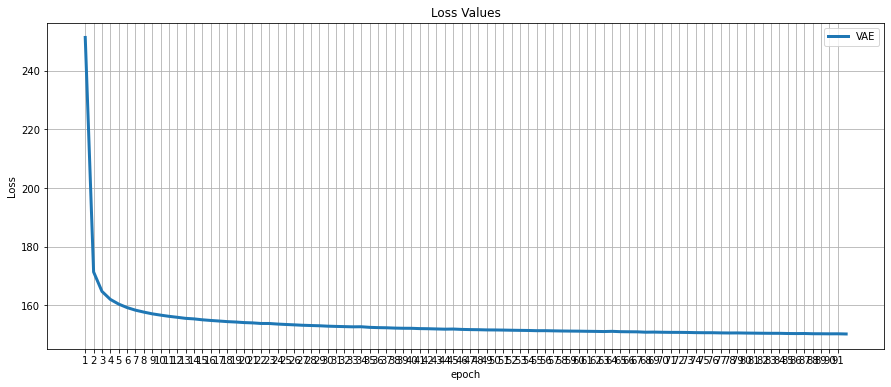

**************************** Epoch:  92


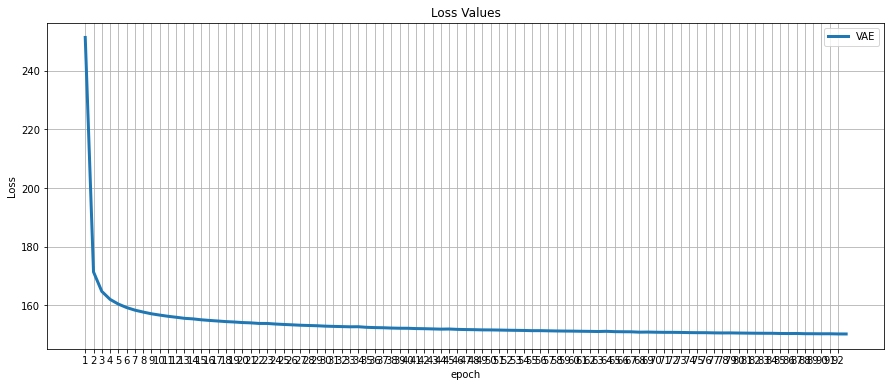

**************************** Epoch:  93


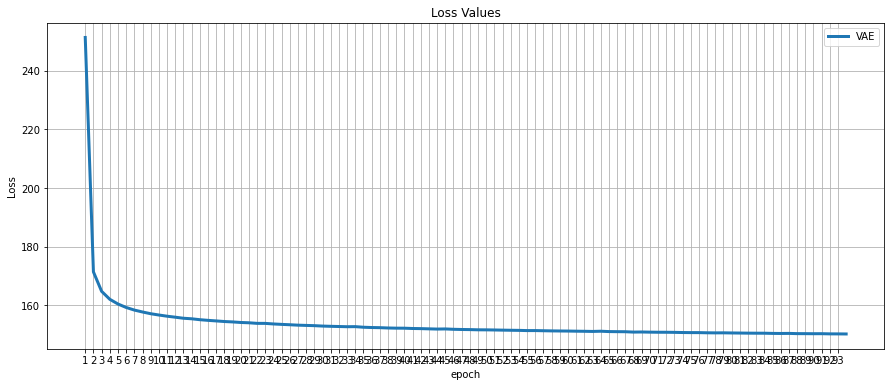

**************************** Epoch:  94


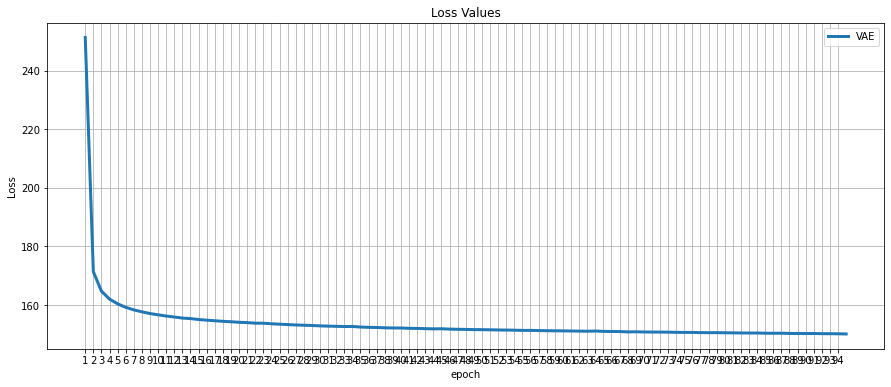

**************************** Epoch:  95


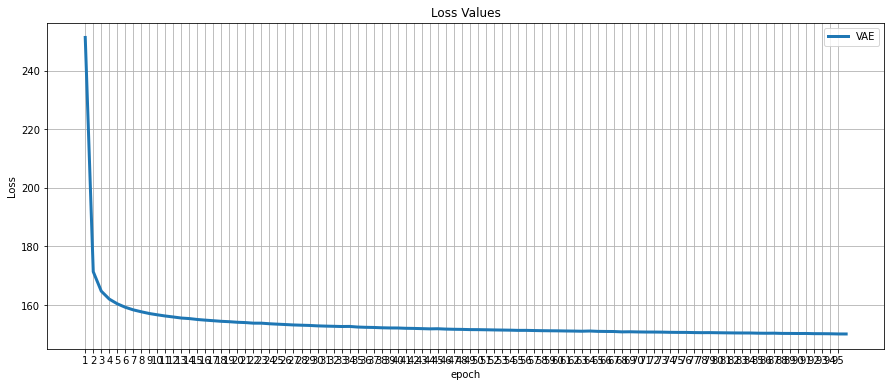

**************************** Epoch:  96


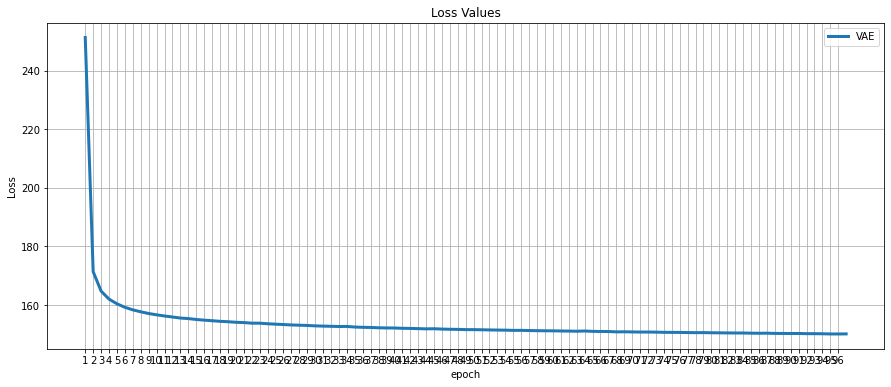

**************************** Epoch:  97


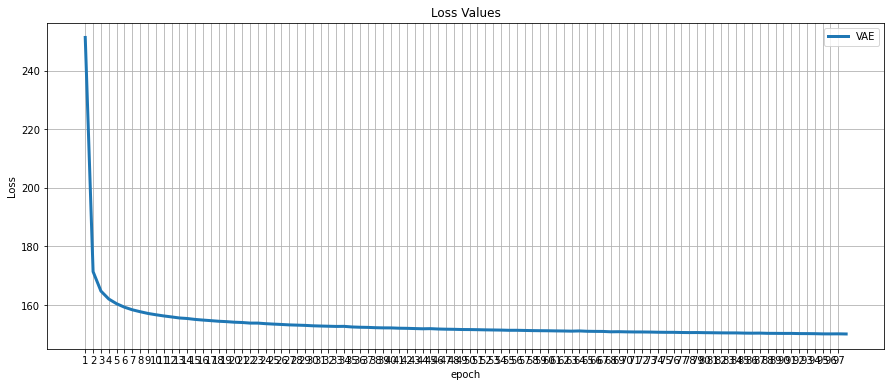

**************************** Epoch:  98


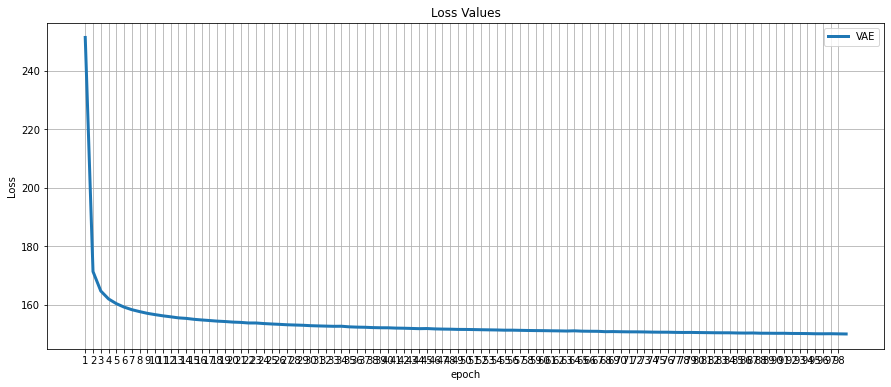

**************************** Epoch:  99


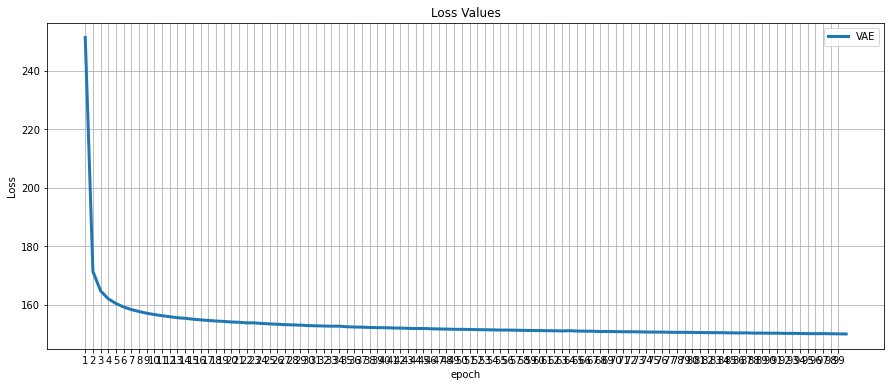

In [ ]:
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')
# Normalize data
input_train = input_train / 255
input_test = input_test / 255
num_batches = int(input_train.shape[0]/BATCH_SIZE)
N_EPOCHS = 100
vae_loss = []
for epoch in range(N_EPOCHS):
  vae_loss_cum = 0
  for batch_idx in range(num_batches):
        images = input_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
        labels = input_test[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
        vae_loss_cum += vae.train_on_batch(images, images)
  vae_loss.append(vae_loss_cum/num_batches)

  # Plot results
  data = (input_test, target_test)
  viz_latent_space(encoder, data)
  print("**************************** Epoch: ", epoch)
  viz_decoded(encoder, decoder, data, epoch)
  plot_diagram(vae_loss,epoch)